# Set up

In [119]:
# Data handling and numerical operations
import pandas as pd                                 # Data manipulation and analysis
import numpy as np                                  # Numerical operations

# Data visualization
import matplotlib.pyplot as plt                     # Plotting graphs
import seaborn as sns                               # Advanced data visualization

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords                   # Stopwords in text processing
from nltk.stem.porter import PorterStemmer          # Stemming words
import re                                           # Regular expression operations
from wordcloud import WordCloud, STOPWORDS          # Generating word cloud visualizations

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

# Utility libraries
import chardet                                      # Detecting character encoding
from collections import Counter
from scipy.sparse import hstack                # Handling collections of data
from scipy.stats import sem
from urllib.parse import urlparse                   # parsing base url values
%matplotlib inline
import logging
# Downloading NLTK resources
# nltk.download('stopwords')

pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Load data from the specified path
df = pd.read_feather("../Data/Data1.feather")

In [120]:
X = df[['text', 'base_url', 'company_names']]
Y = df['sentiment']

In [121]:
stop_words_appened=stopwords.words('english').append(['rt', 'ep'])

# TF-IDF Vectorizer

In [122]:

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_text = tfidf_vectorizer_text.fit_transform(X_train['text'])
X_test_tfidf_text = tfidf_vectorizer_text.transform(X_test['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_url = tfidf_vectorizer_url.fit_transform(X_train['base_url'])
X_test_tfidf_url = tfidf_vectorizer_url.transform(X_test['base_url'])

# Creating TF-IDF vectorizer for company_names
tfidf_vectorizer_company = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_company = tfidf_vectorizer_url.fit_transform(X_train['company_names'])
X_test_tfidf_company = tfidf_vectorizer_url.transform(X_test['company_names'])

# Concatenating the TF-IDF matrices horizontally
X_train_tfidf_combined = hstack([X_train_tfidf_text, X_train_tfidf_url, X_train_tfidf_company])
X_test_tfidf_combined = hstack([X_test_tfidf_text, X_test_tfidf_url, X_test_tfidf_company])

# Creating and training the logistic regression model
Reg_tf = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight='balanced')
Reg_tf.fit(X_train_tfidf_combined, y_train)

# Predicting on the test set
y_pred = Reg_tf.predict(X_test_tfidf_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9084952024338872
              precision    recall  f1-score   support

          -1       0.74      0.80      0.77       389
           0       0.93      0.93      0.93      2584
           1       0.92      0.89      0.91      1300

    accuracy                           0.91      4273
   macro avg       0.86      0.88      0.87      4273
weighted avg       0.91      0.91      0.91      4273



In [123]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 312,   57,   20],
       [  91, 2410,   83],
       [  21,  119, 1160]])

## Confusion Matrix

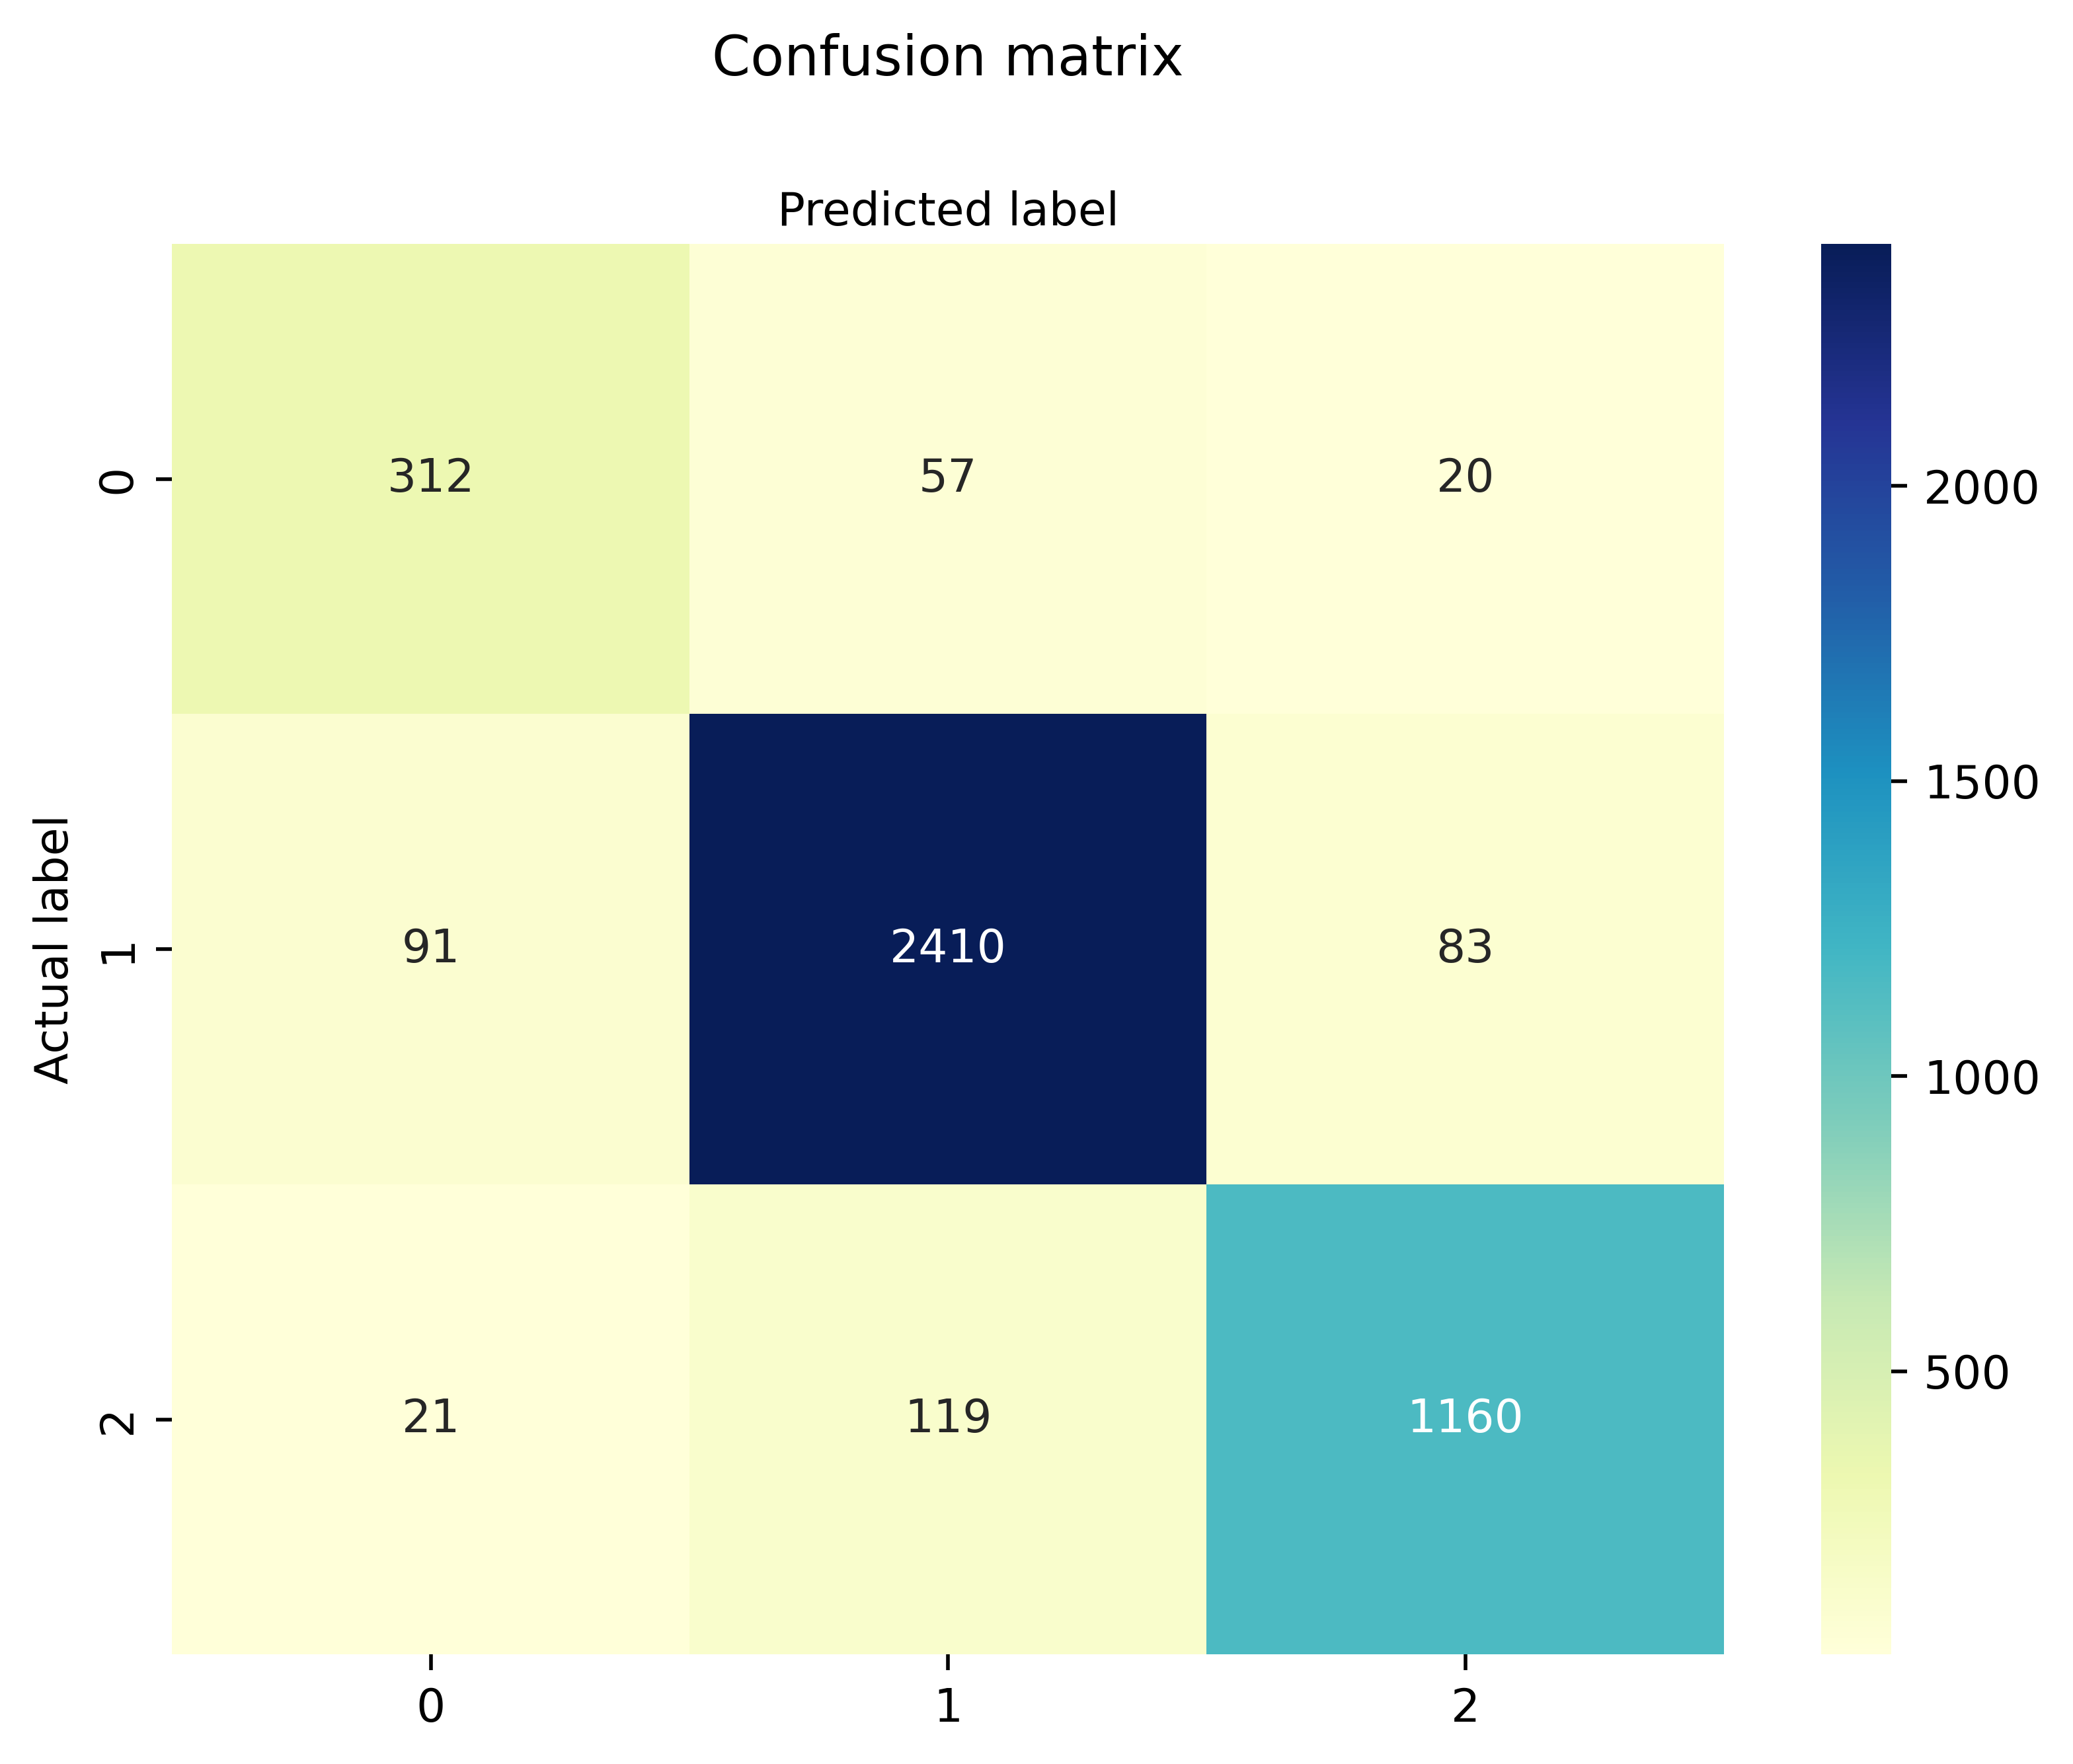

In [124]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

## ROC Curve Analysis

In [125]:
# ROC with one vs rest multiclass
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4273, 3)

In [126]:
# changing labels to binary data
label_binarizer.transform([-1])

array([[1, 0, 0]])

In [127]:
# ROC curve showing an individual class
class_of_interest = 0 # neutral sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = Reg_tf.predict_proba(X_test_tfidf_combined)
class_id

1

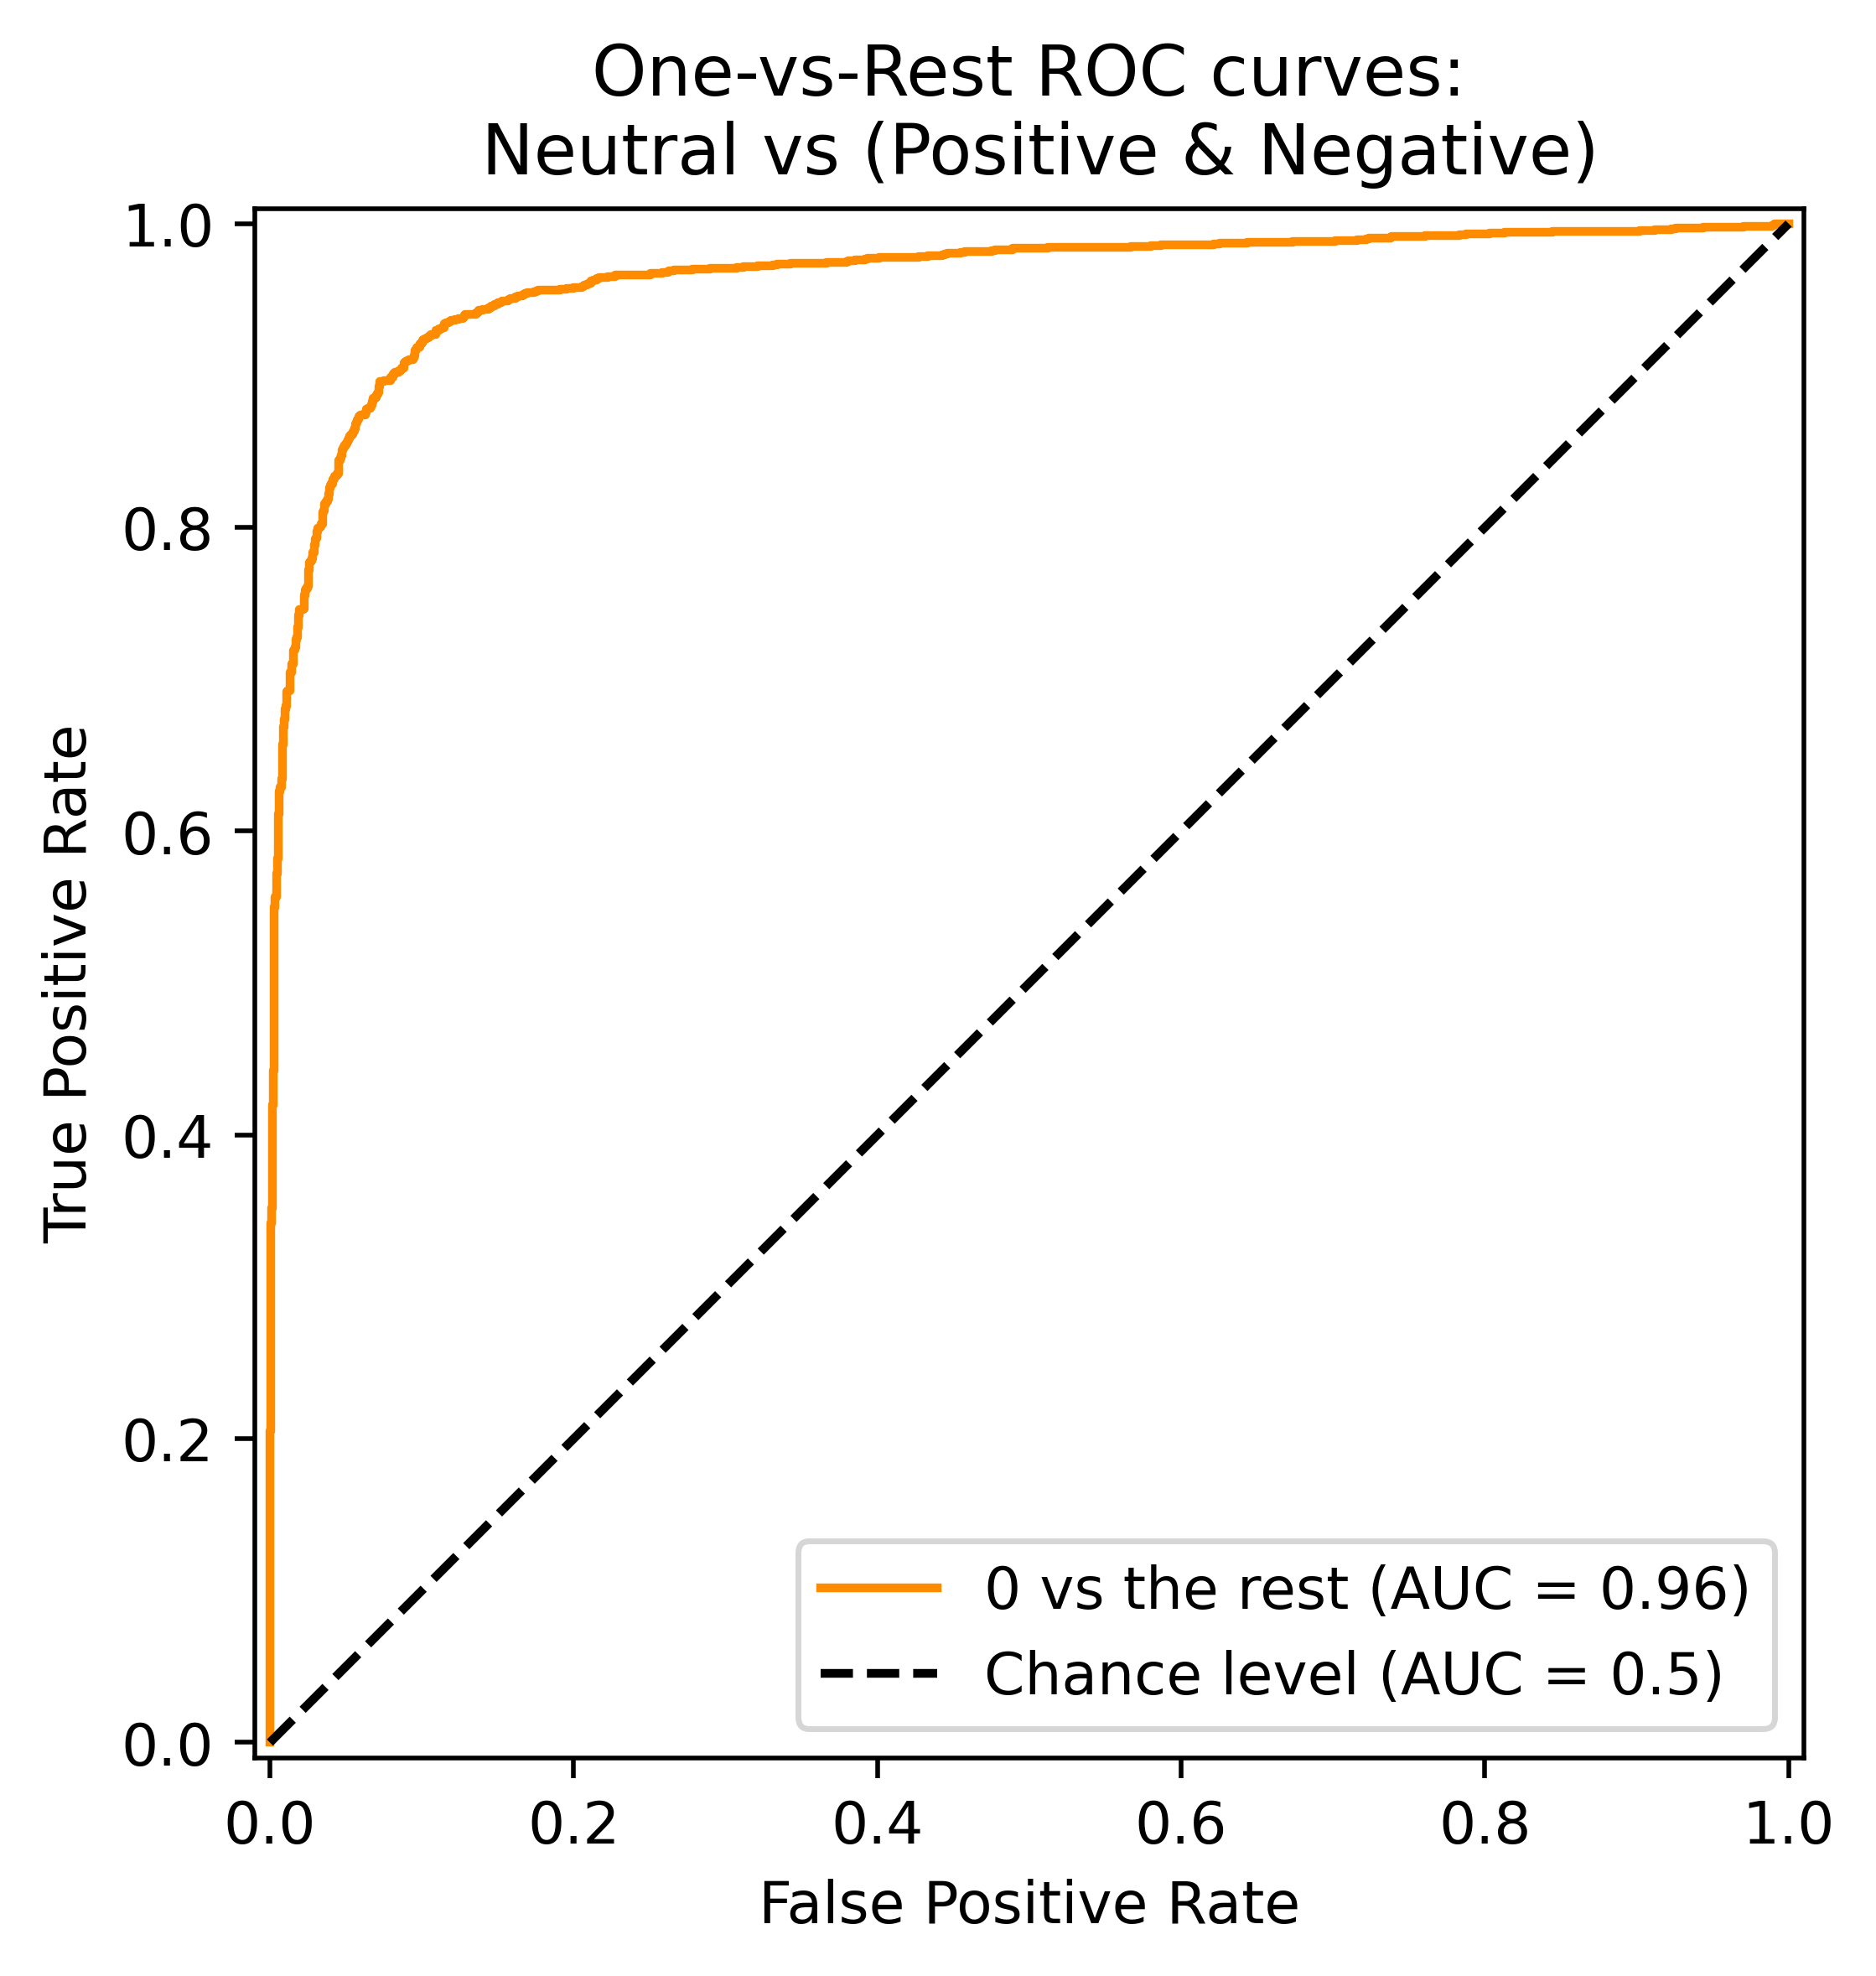

In [128]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Neutral vs (Positive & Negative)",
)

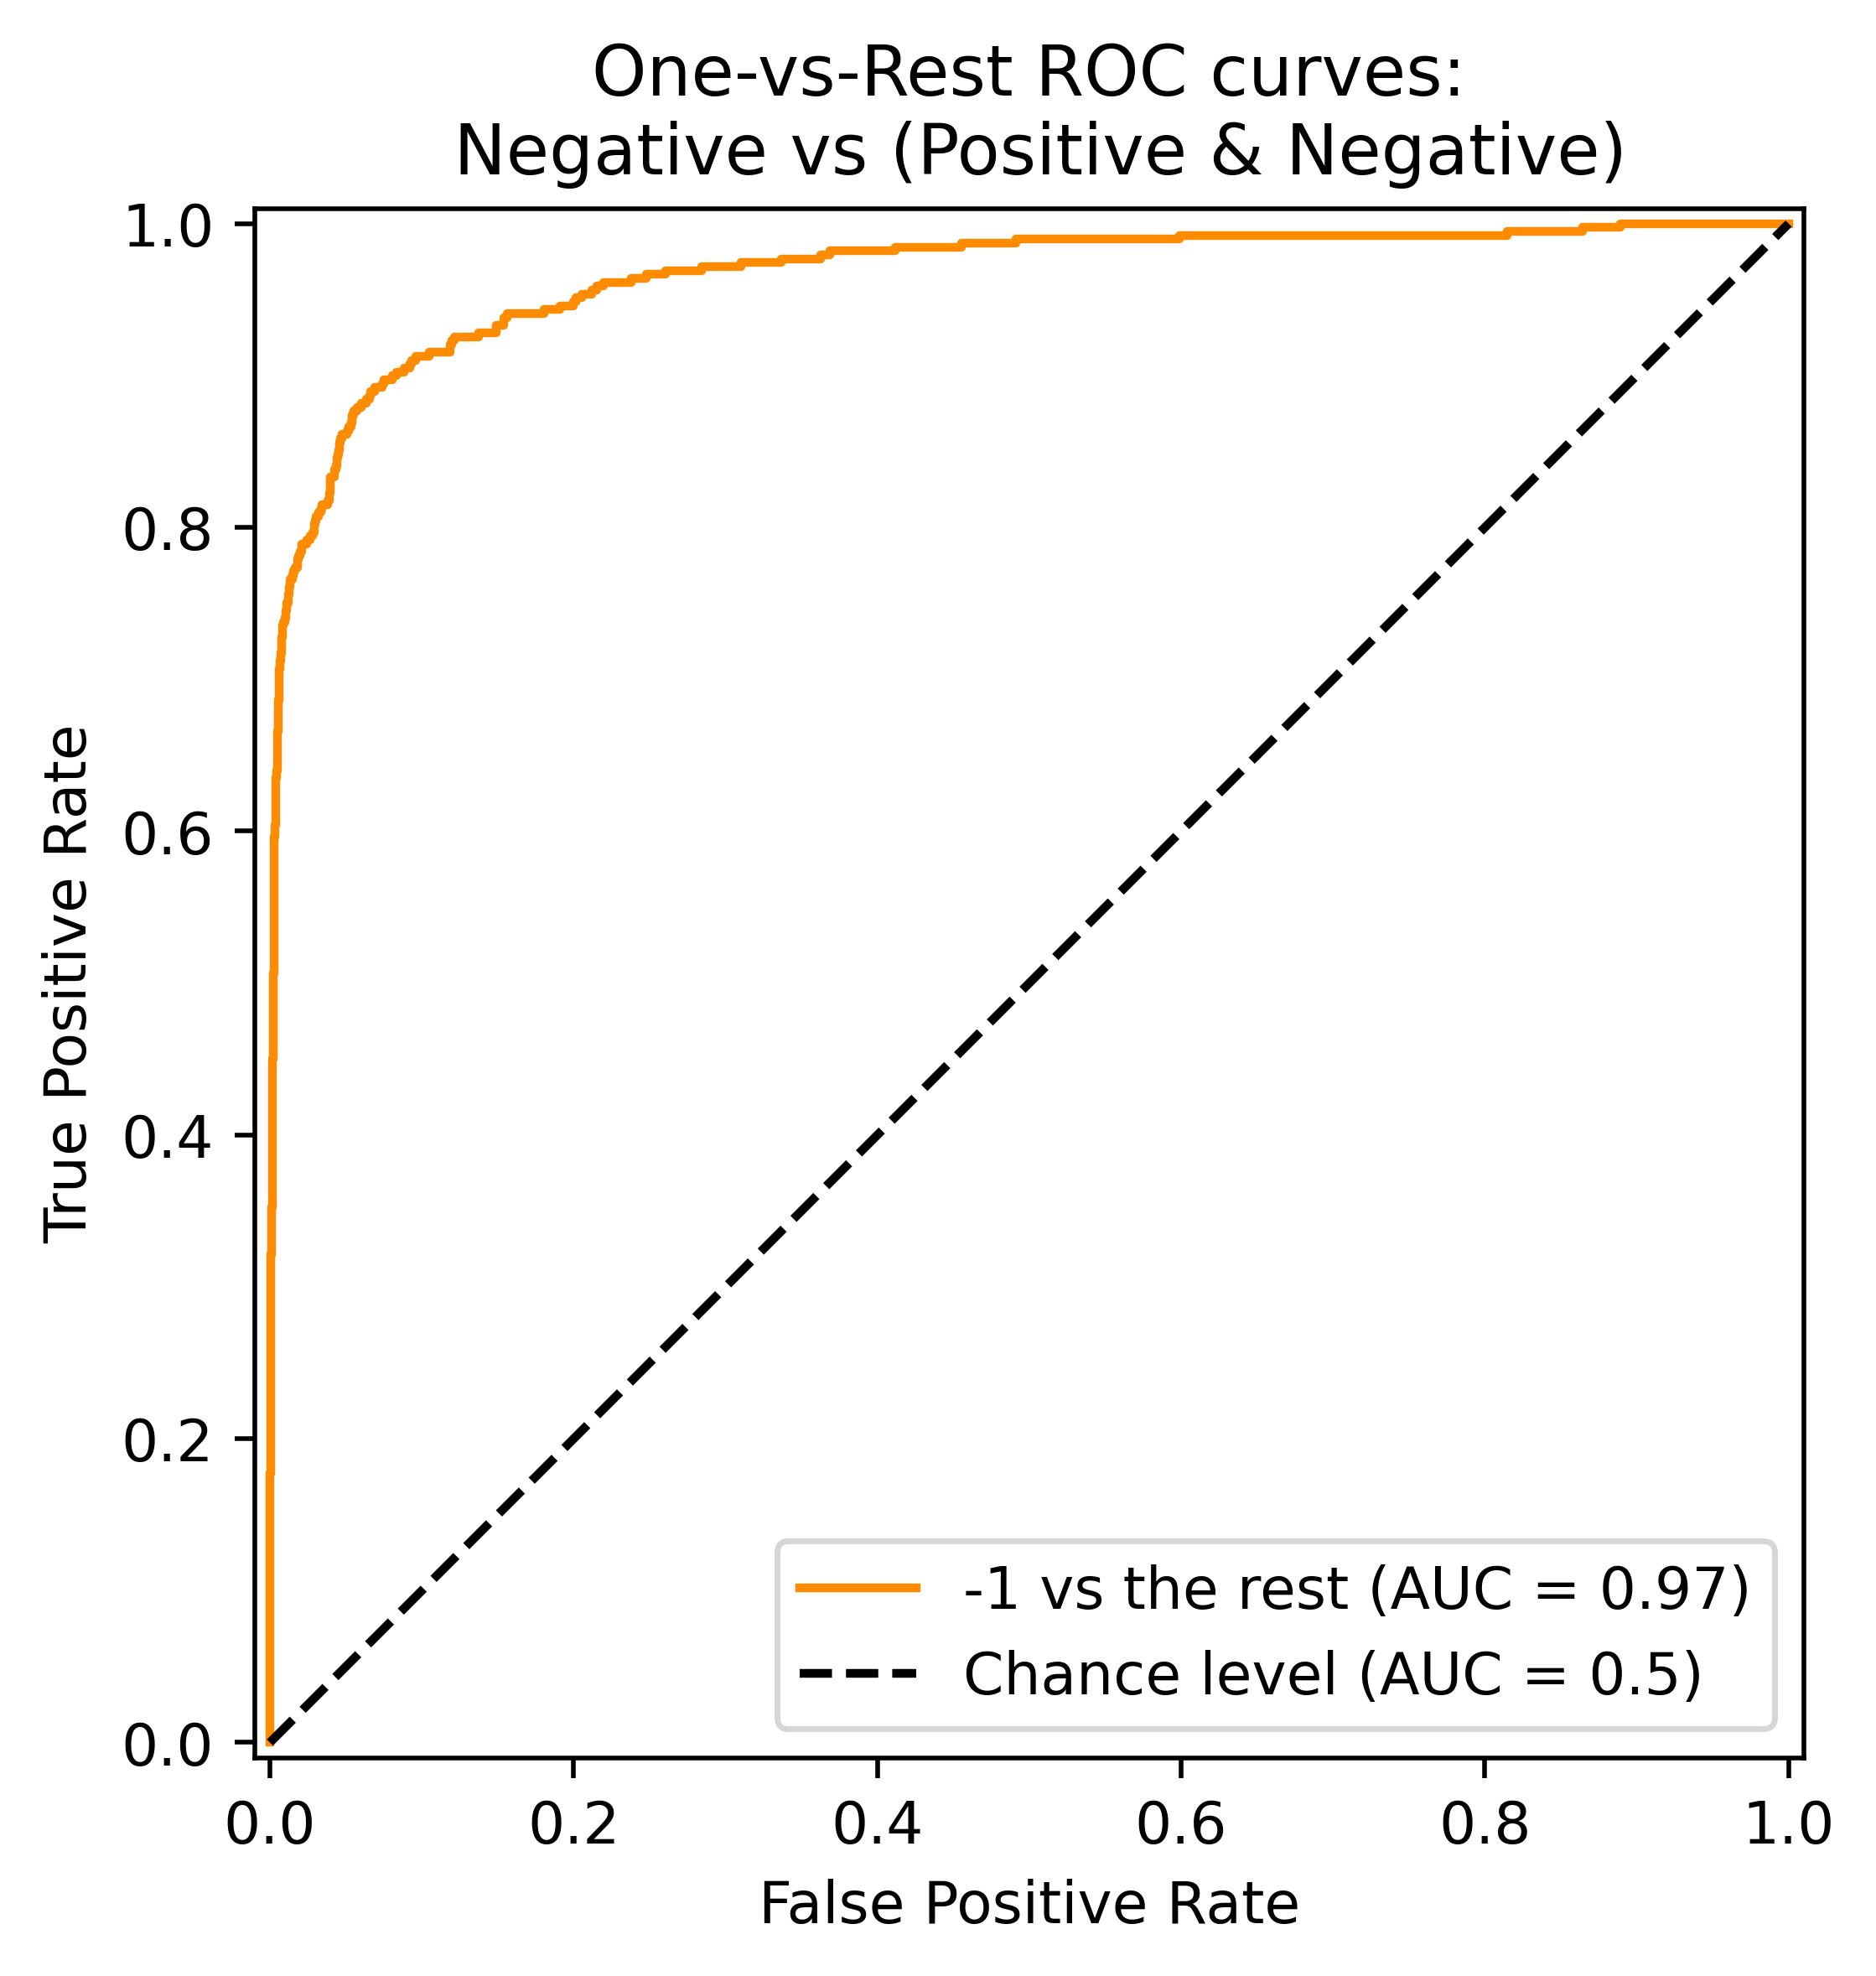

In [129]:
# for negative sentiments
# ROC curve showing an individual class
class_of_interest = -1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Negative vs (Positive & Negative)",
)

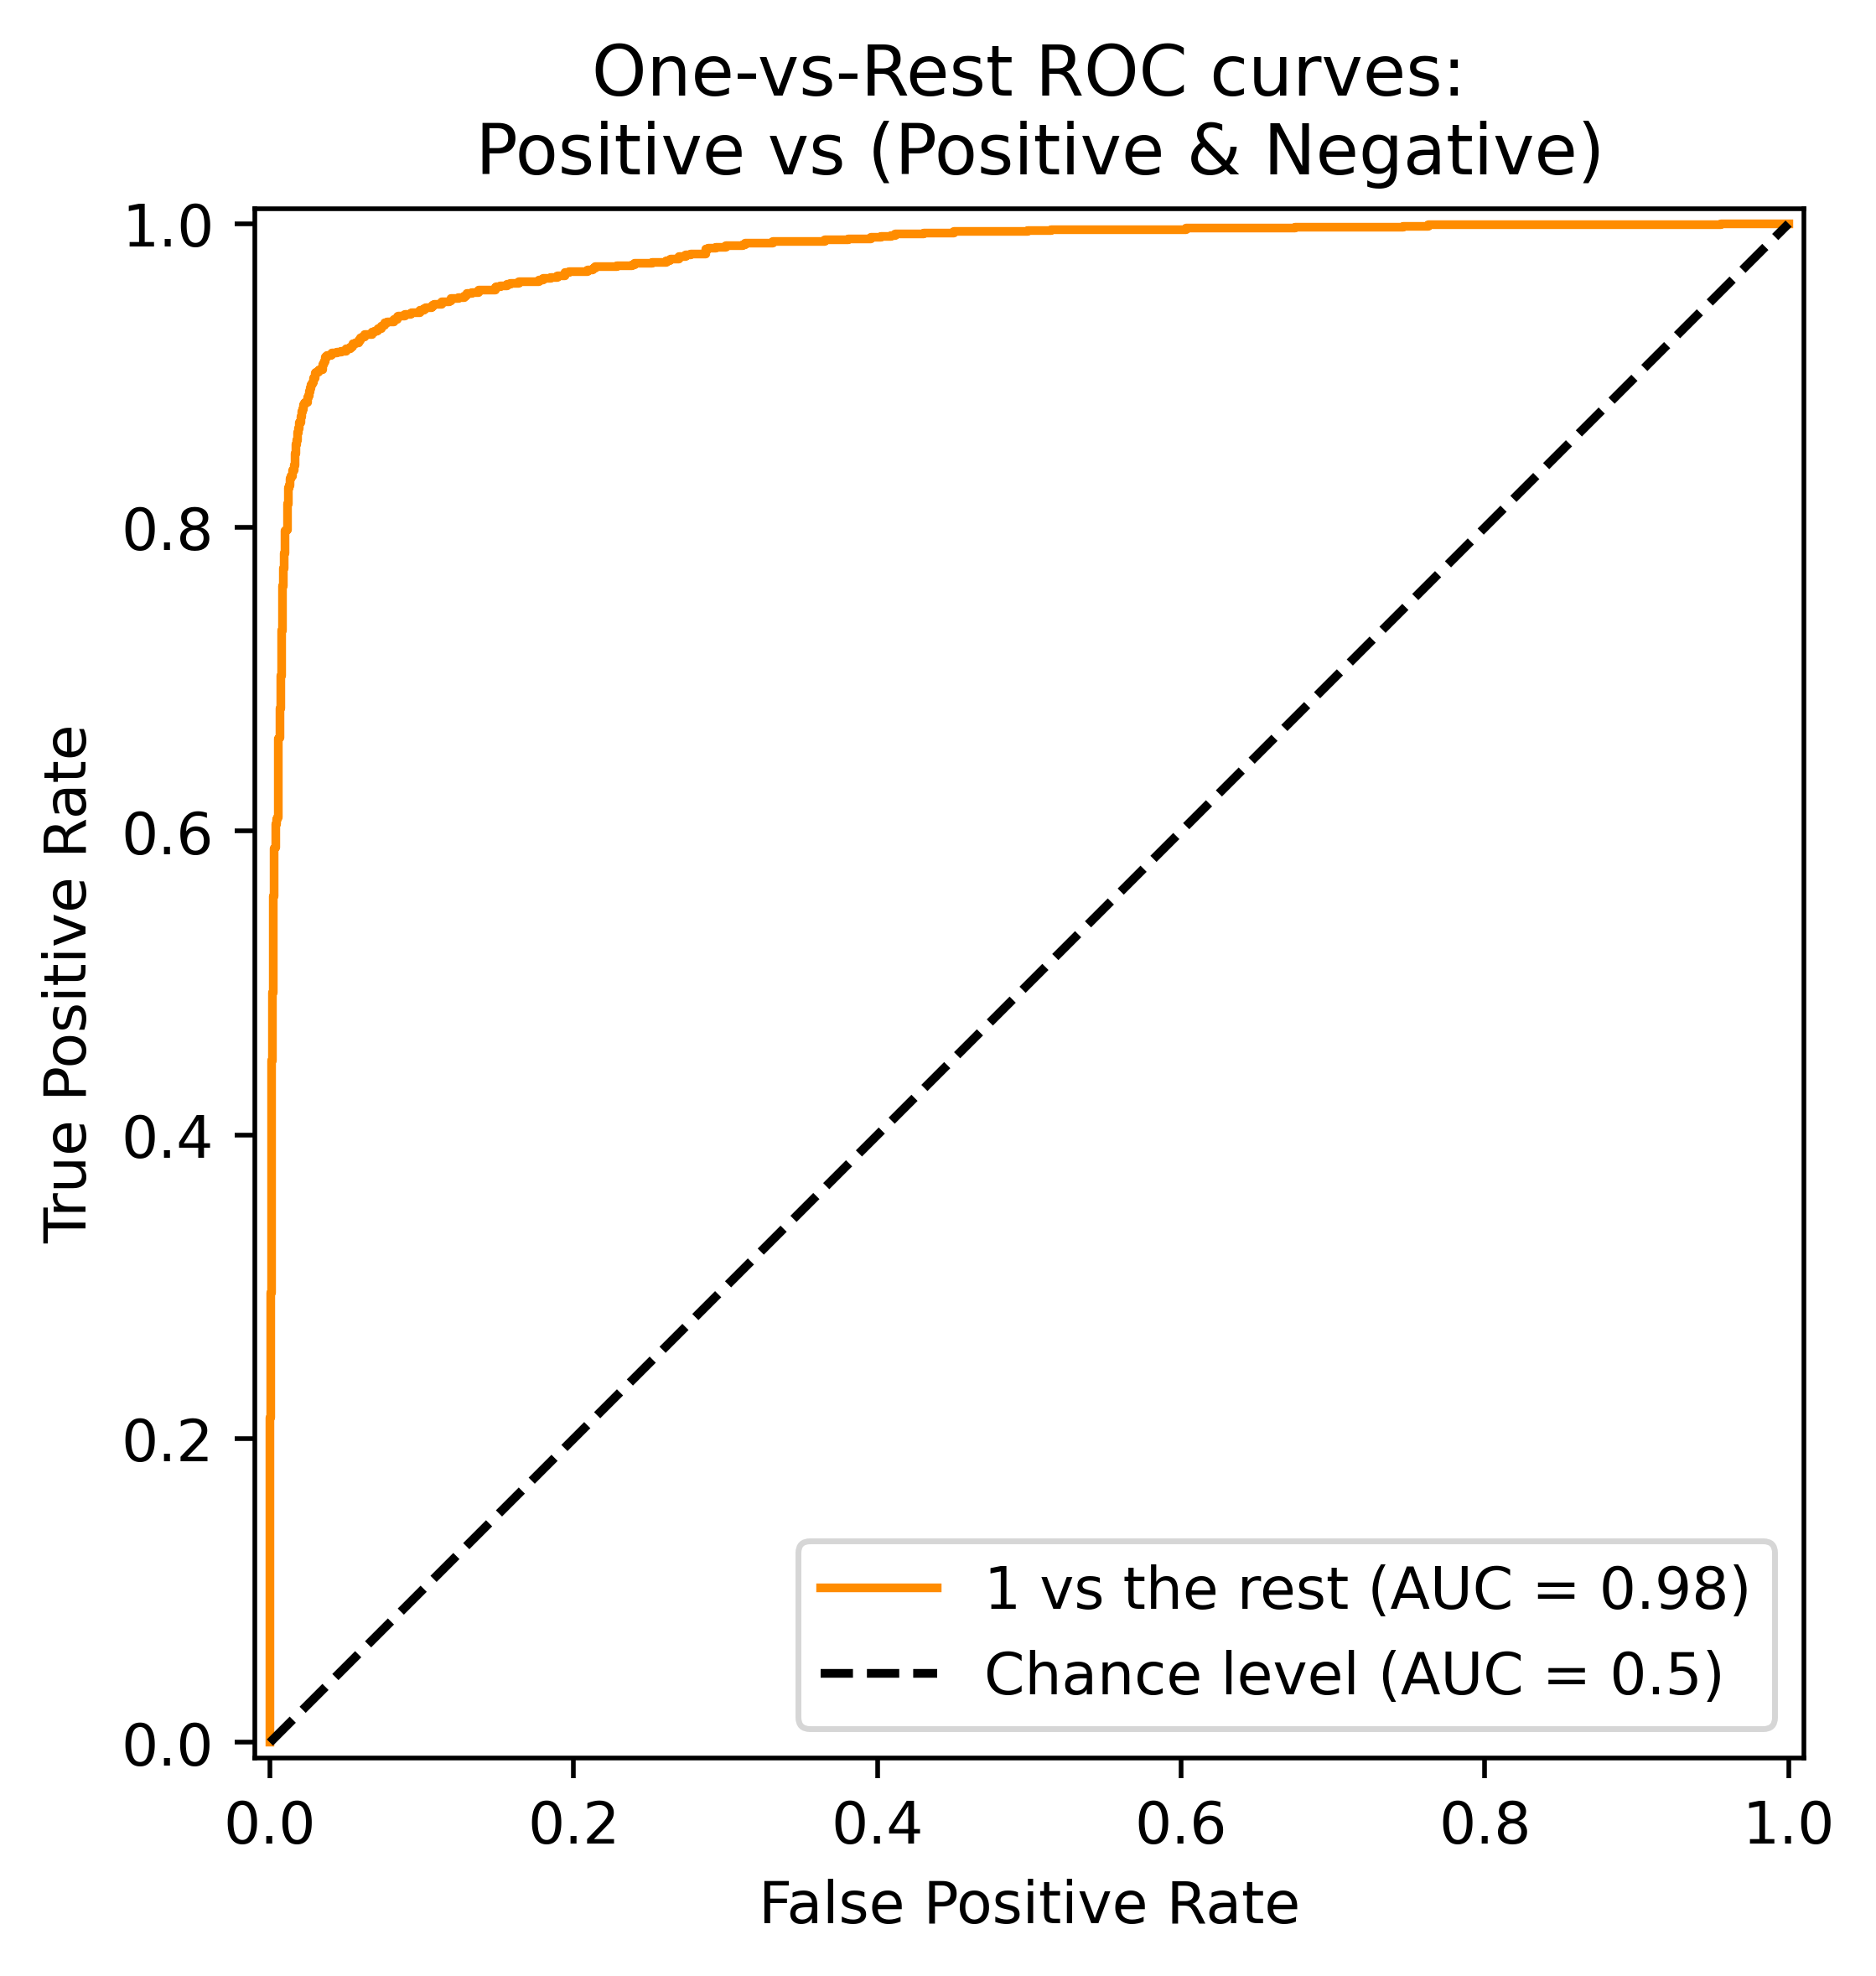

In [130]:
# for positive sentiments
# ROC curve showing an individual class
class_of_interest = 1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Positive vs (Positive & Negative)",
)

### ROC Micro-Averaged

Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics. In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferred.

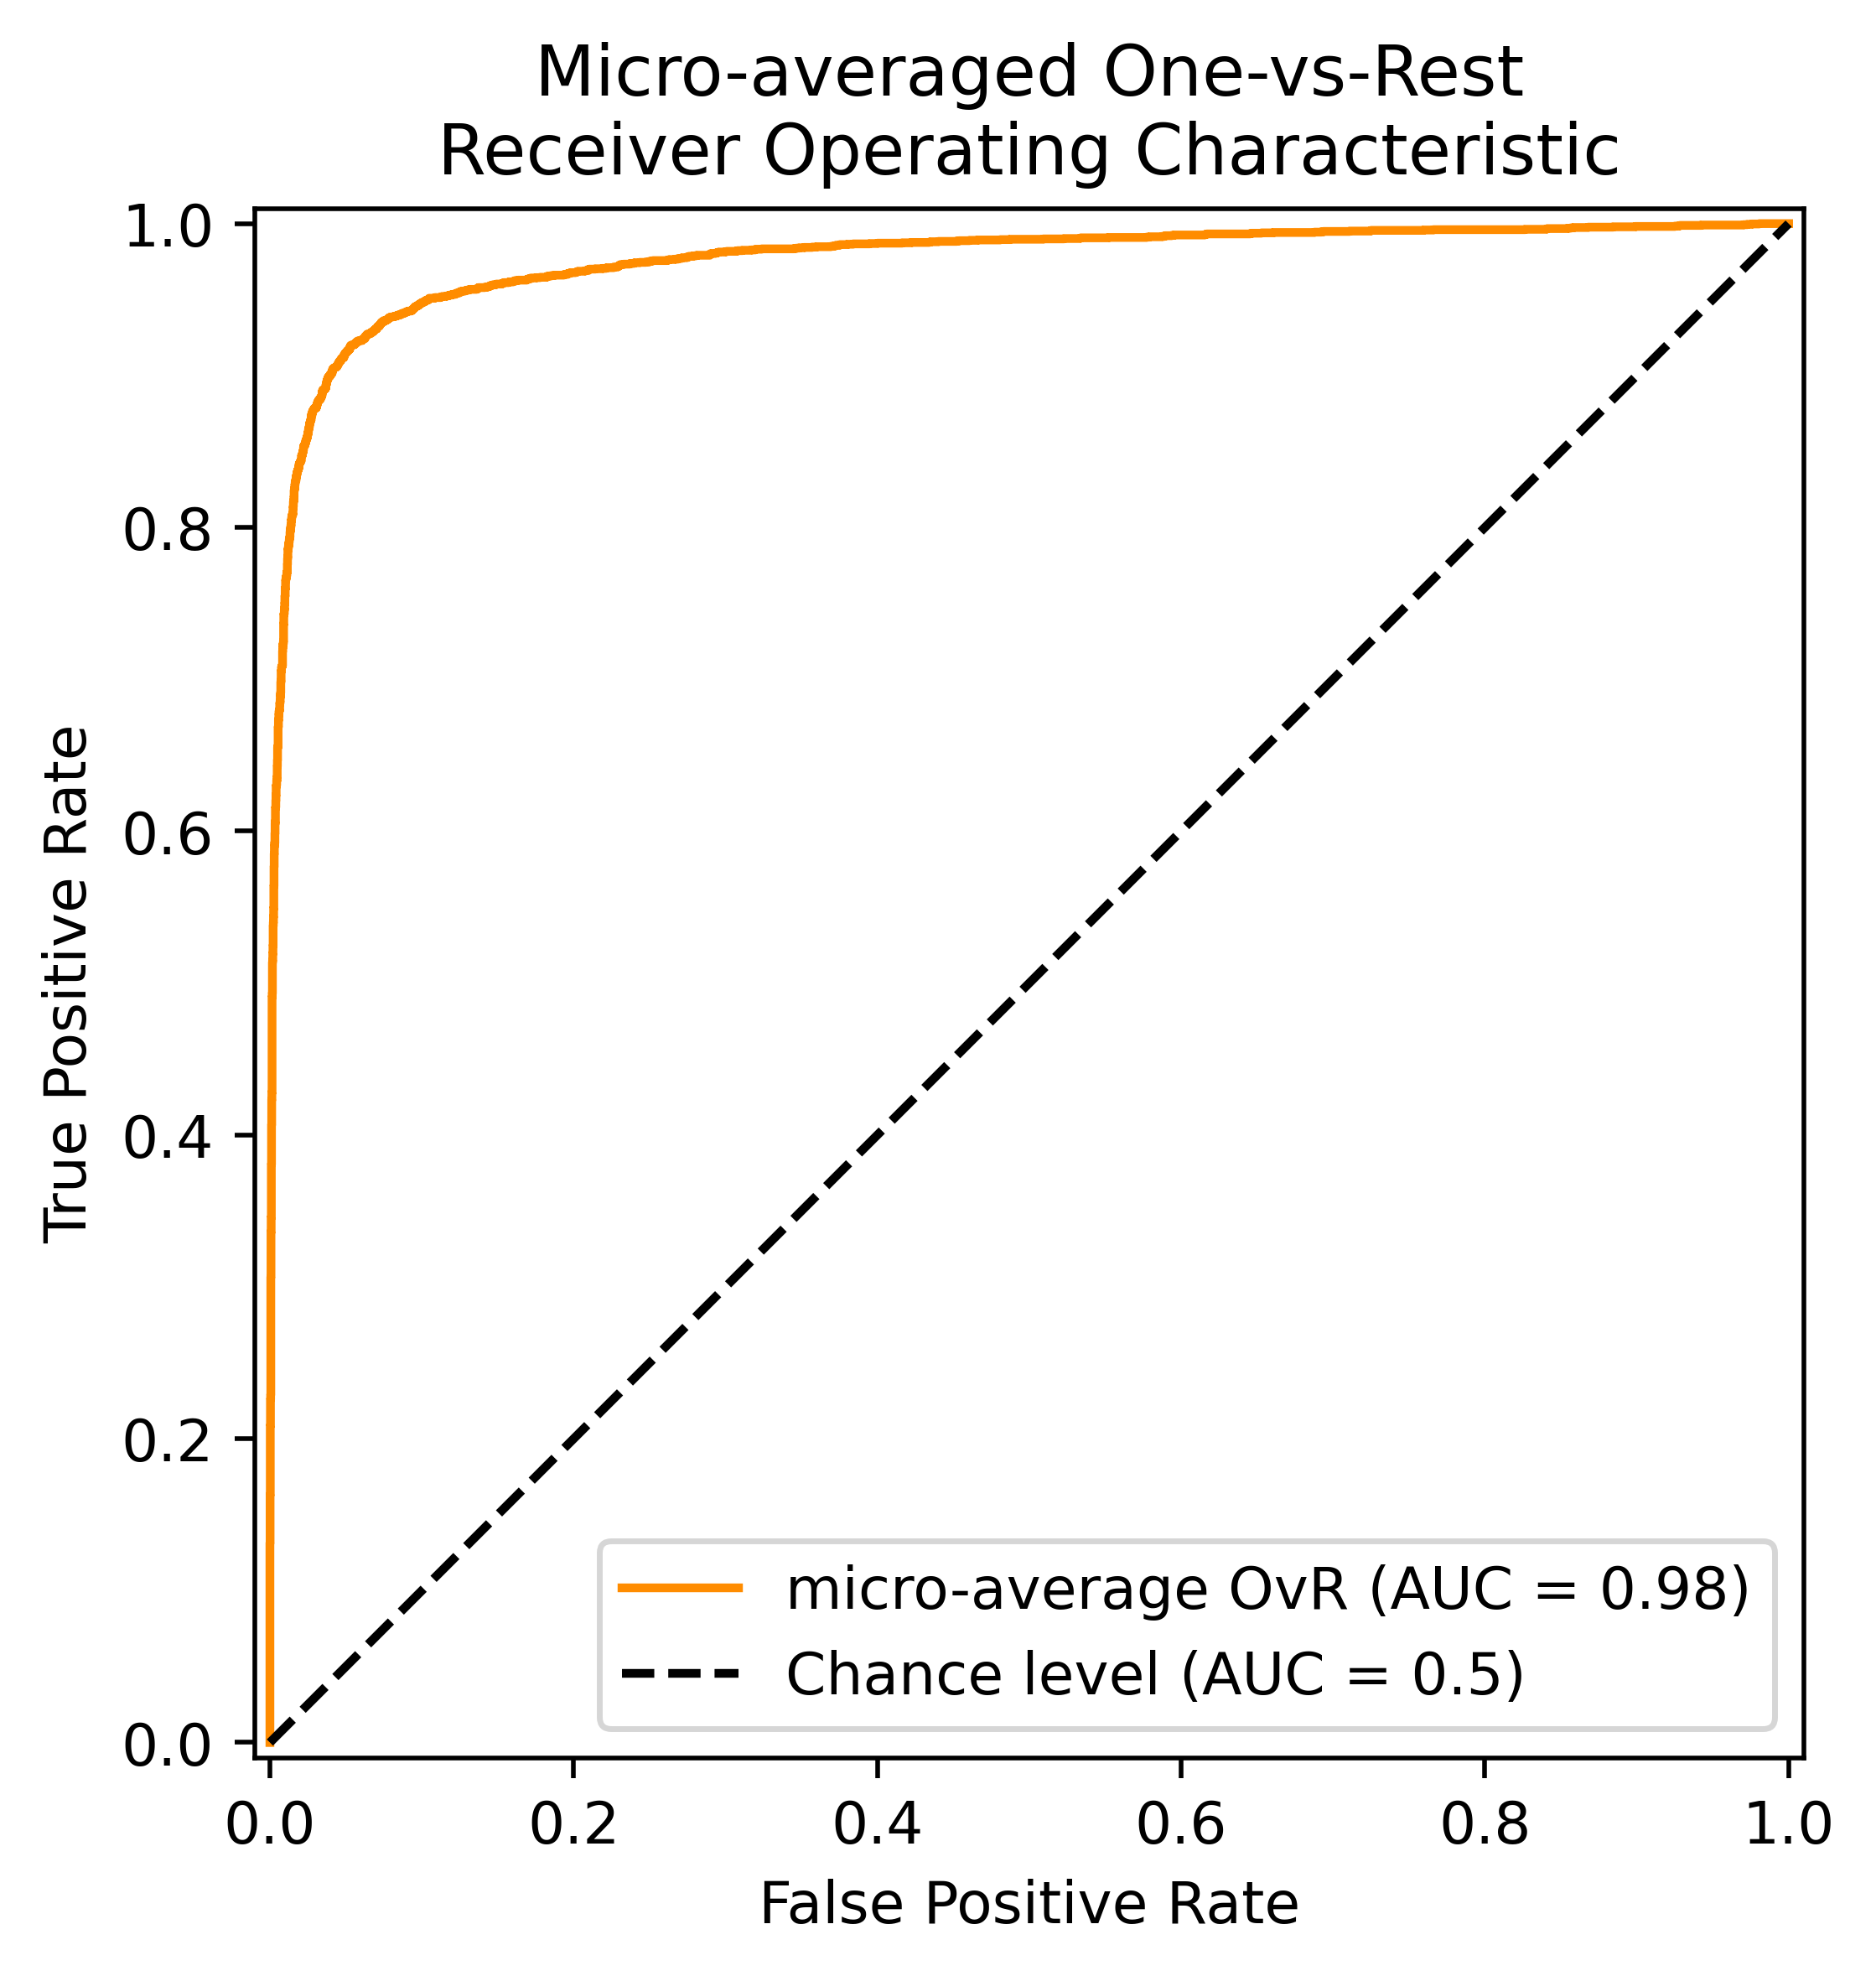

In [131]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [132]:
# computing ROC-AUC score
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9756499003835413


In [133]:
# Calculate ROC curve and ROC AUC for each class
from sklearn.metrics import roc_curve

fpr = {}
tpr = {}
thresholds = {}
roc_auc = {}

for i, class_ in enumerate(label_binarizer.classes_):
    fpr[class_], tpr[class_], thresholds[class_] = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[class_] = roc_auc_score(y_onehot_test[:, i], y_score[:, i])

# Calculate micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = roc_auc_score(y_onehot_test, y_score, average="micro")

# Export ROC data to CSV
roc_data = []
for key in roc_auc:
    for fp, tp, thres in zip(fpr[key], tpr[key], thresholds[key]):
        roc_data.append([key, fp, tp, thres, roc_auc[key]])

roc_df = pd.DataFrame(roc_data, columns=['Class', 'FPR', 'TPR', 'Thresholds', 'AUC'])
roc_df.to_csv('roc_data/1/roc_data_tfidf.csv', index=False)

print("Saved.")

Saved.


# Bag-Of-Words Vectorizer

In [134]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)

# Fitting and transforming the text training set
X_train_bow_text = bow_vectorizer_text.fit_transform(X_train['text'])
X_test_bow_text = bow_vectorizer_text.transform(X_test['text'])
bow_vectorizer_url = CountVectorizer(max_features=1000)

# Fitting and transforming the url training set
X_train_bow_url = bow_vectorizer_url.fit_transform(X_train['base_url'])
X_test_bow_url = bow_vectorizer_url.transform(X_test['base_url'])
X_train_bow_company_name = bow_vectorizer_url.fit_transform(X_train['company_names'])
X_test_bow_company_name = bow_vectorizer_url.transform(X_test['company_names'])
X_train_bow_combined = hstack([X_train_bow_text, X_train_bow_url, X_train_bow_company_name])
X_test_bow_combined = hstack([X_test_bow_text, X_test_bow_url, X_test_bow_company_name])

# Creating and training the logistic regression model
logreg_model = LogisticRegression(multi_class='ovr', solver='liblinear')
logreg_model.fit(X_train_bow_combined, y_train)

# Predicting on the test set
y_pred = logreg_model.predict(X_test_bow_combined)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9262813011935408
              precision    recall  f1-score   support

          -1       0.87      0.76      0.81       389
           0       0.93      0.96      0.95      2584
           1       0.94      0.90      0.92      1300

    accuracy                           0.93      4273
   macro avg       0.91      0.88      0.89      4273
weighted avg       0.93      0.93      0.93      4273



In [135]:
# confusion matrix
cm_bow = confusion_matrix(y_test, y_pred)
cm_bow

array([[ 297,   76,   16],
       [  33, 2488,   63],
       [  12,  115, 1173]])

## Confusion Matrix

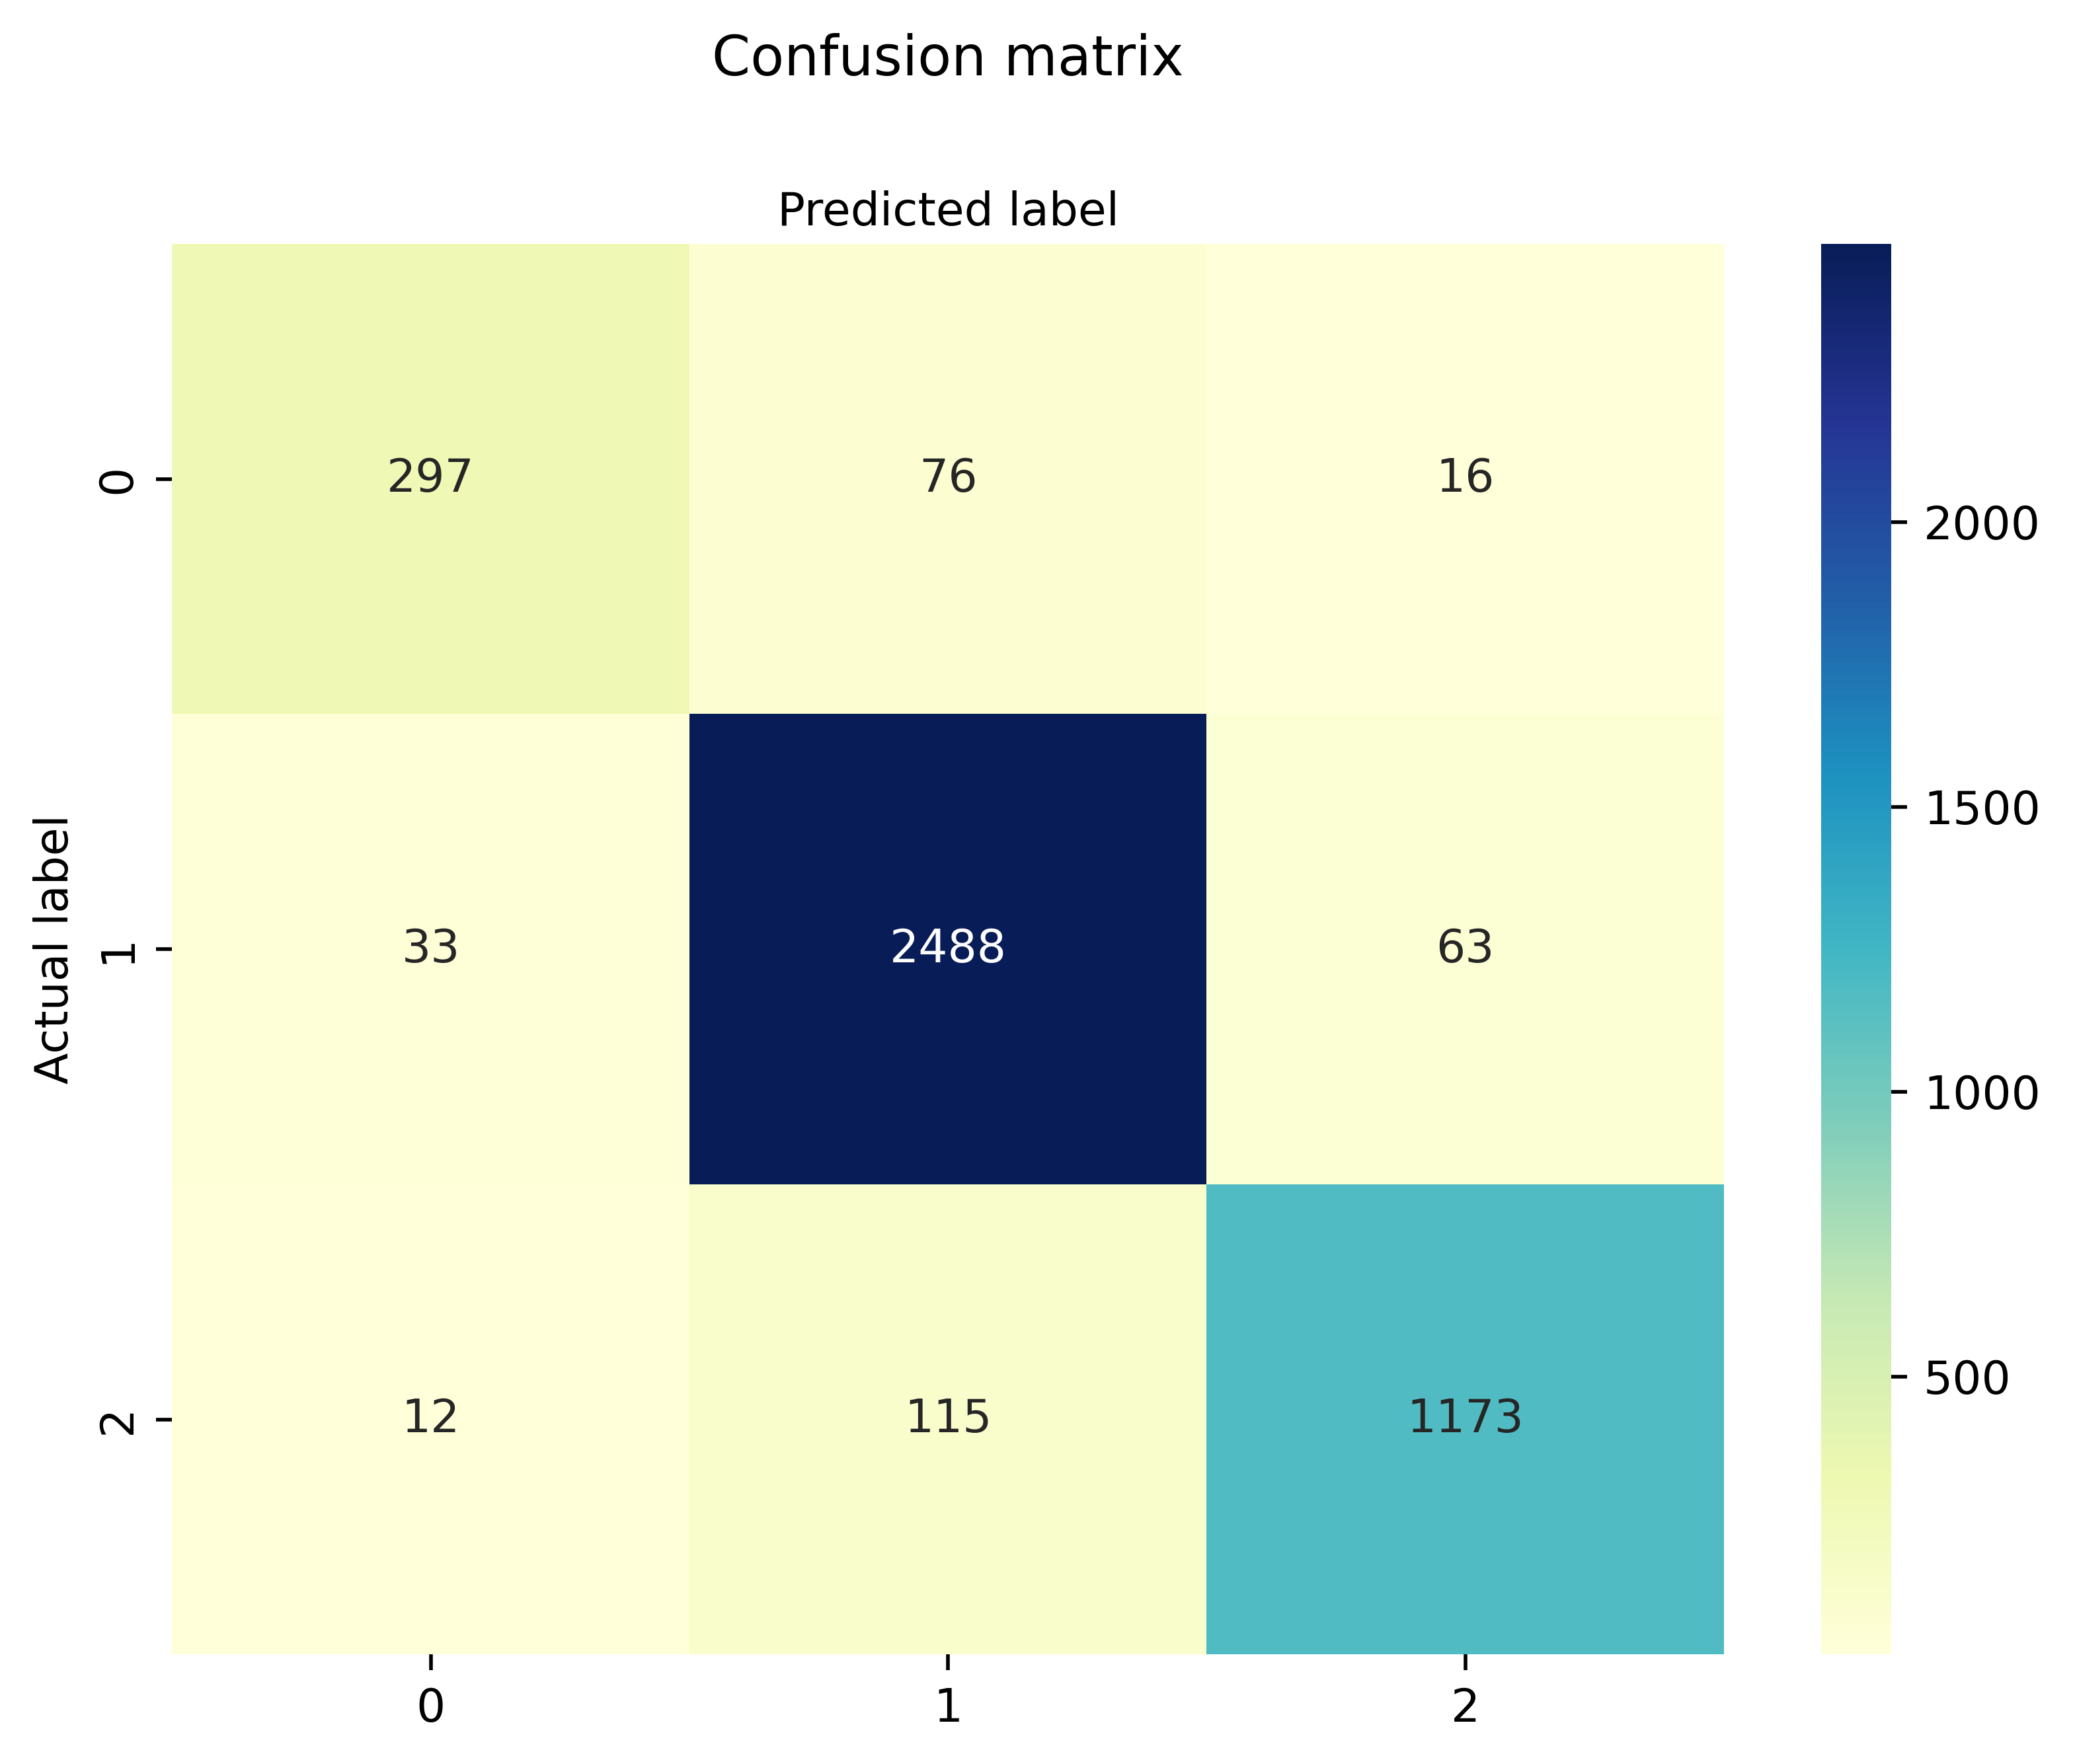

In [136]:
# plotting confusion matrix
plot_conf_mat(cm_bow)

## ROC Curve Analysis

In [137]:
# ROC with one vs rest multiclass
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4273, 3)

In [138]:
label_binarizer.transform([-1])

array([[1, 0, 0]])

In [139]:
# ROC curve showing an individual class
class_of_interest = 0 # neutral sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = Reg_tf.predict_proba(X_test_bow_combined)
class_id

1

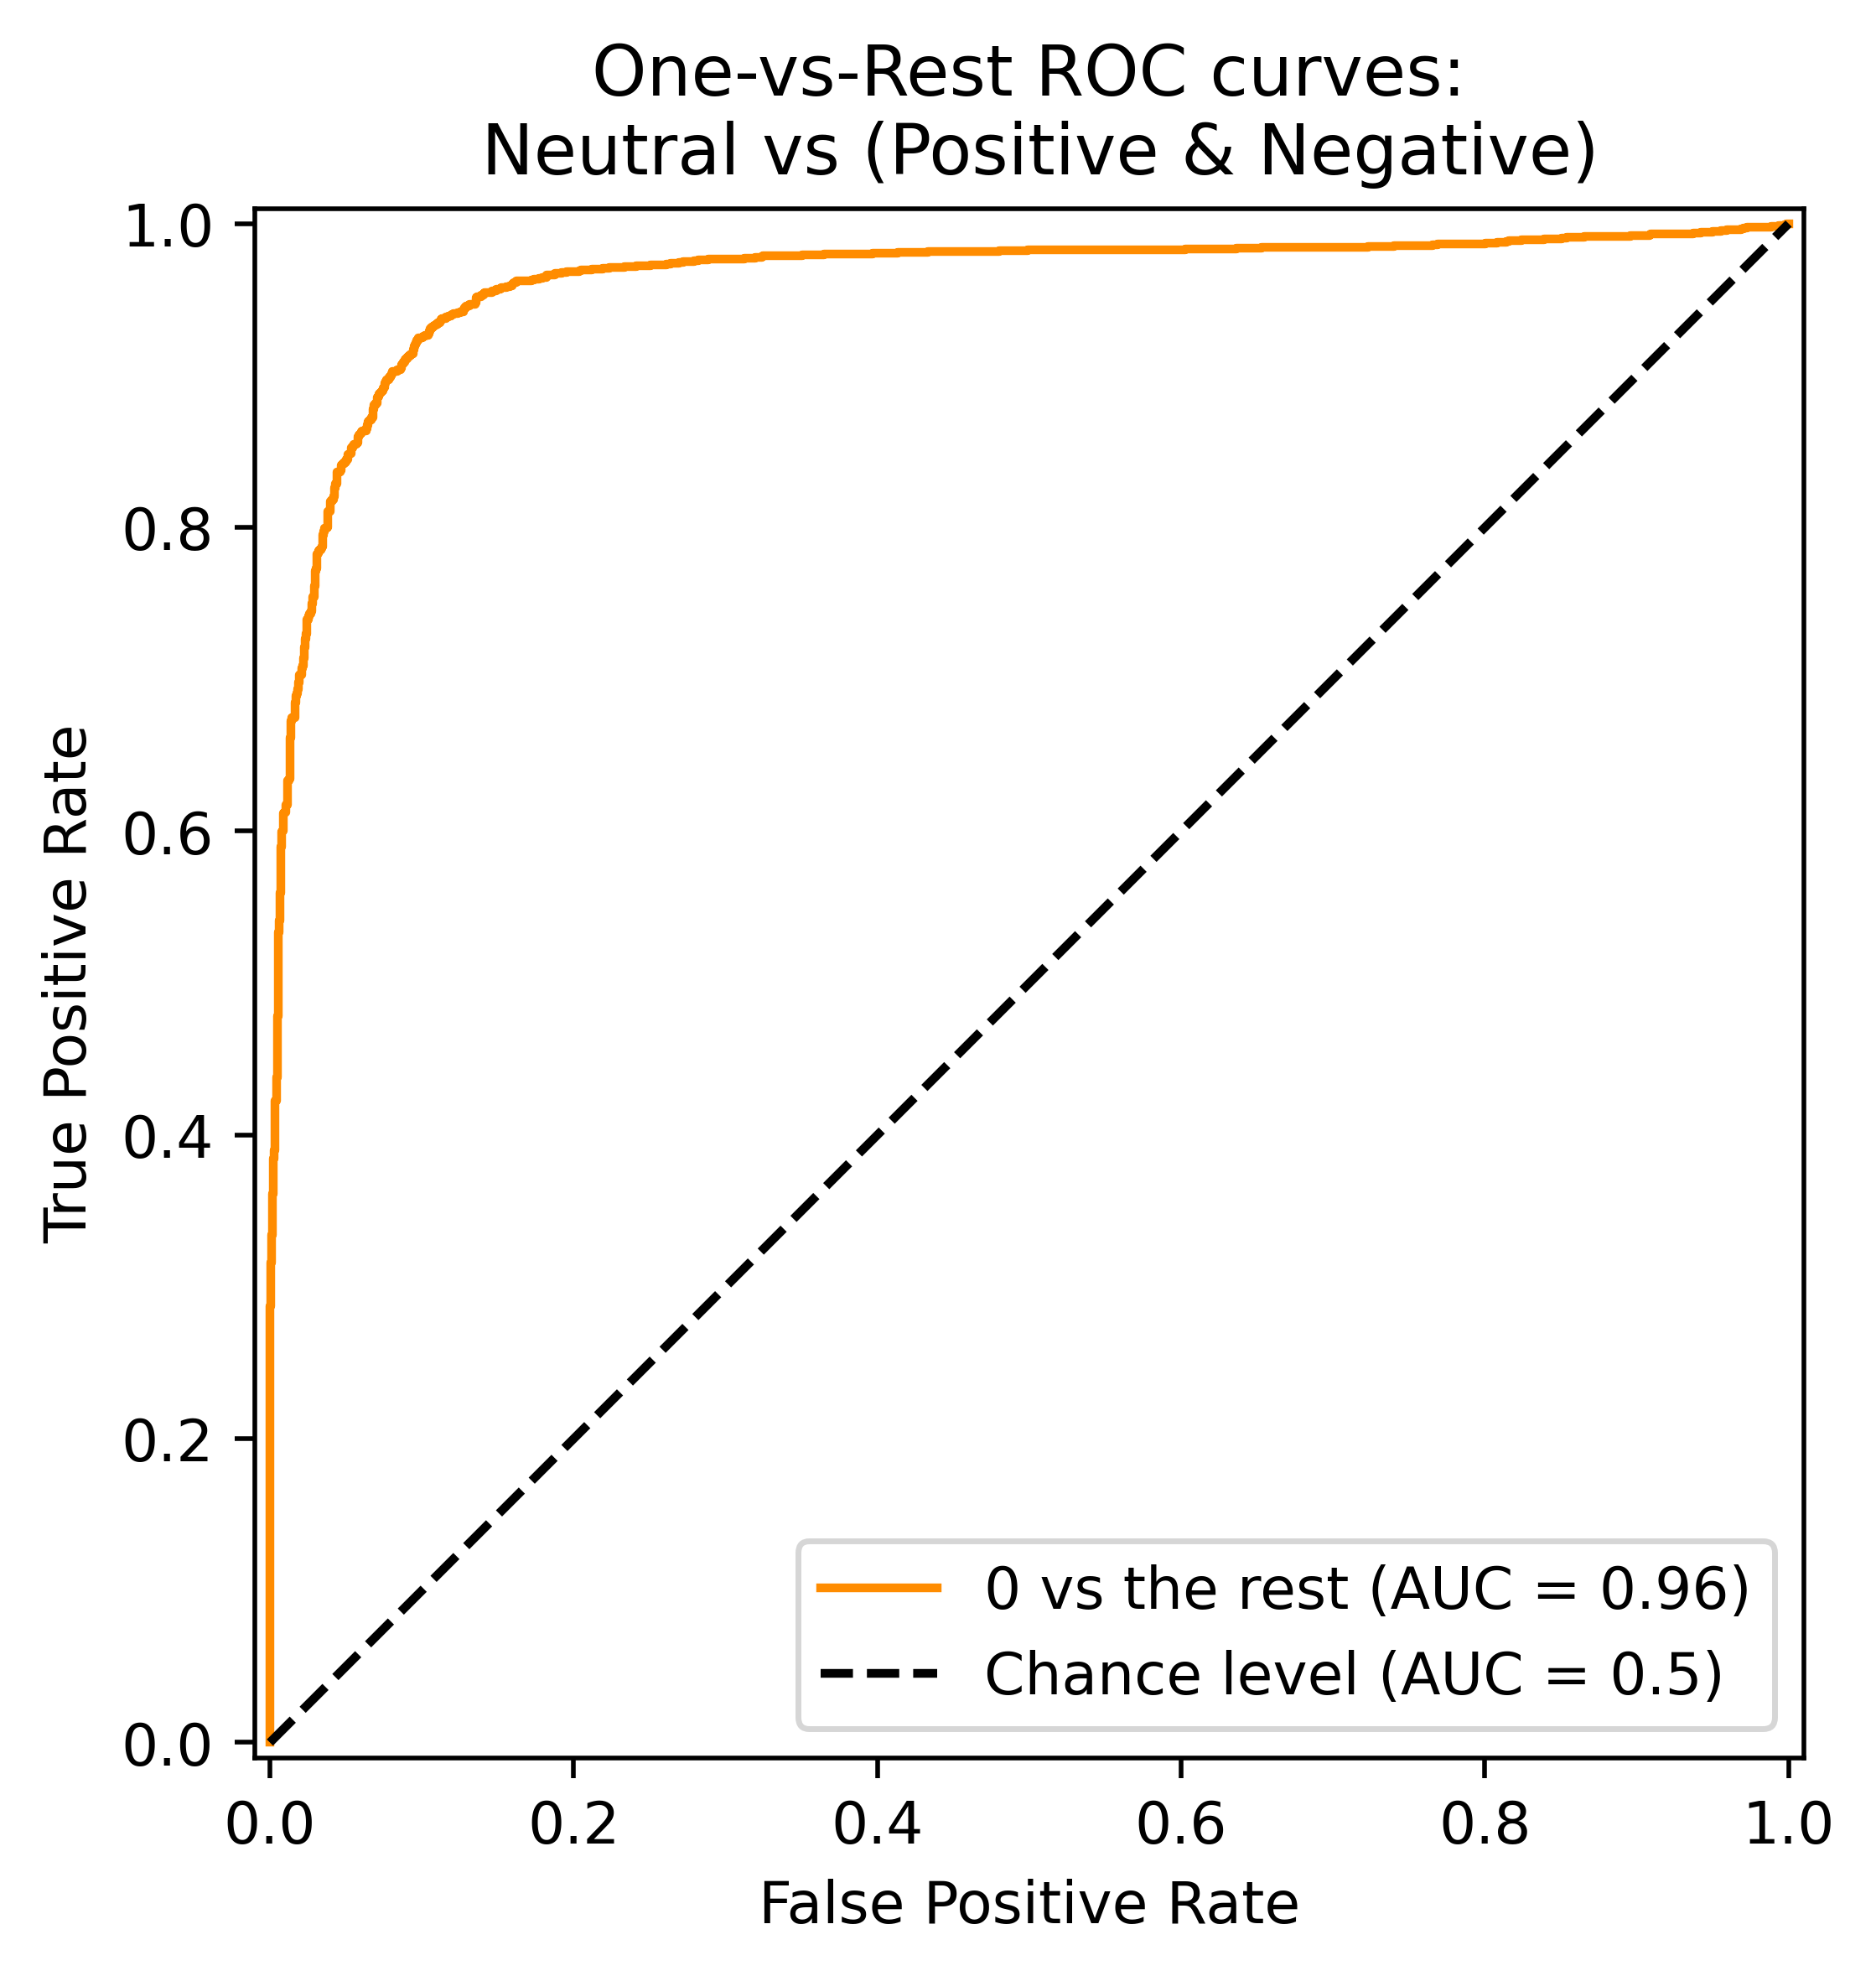

In [140]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Neutral vs (Positive & Negative)",
)

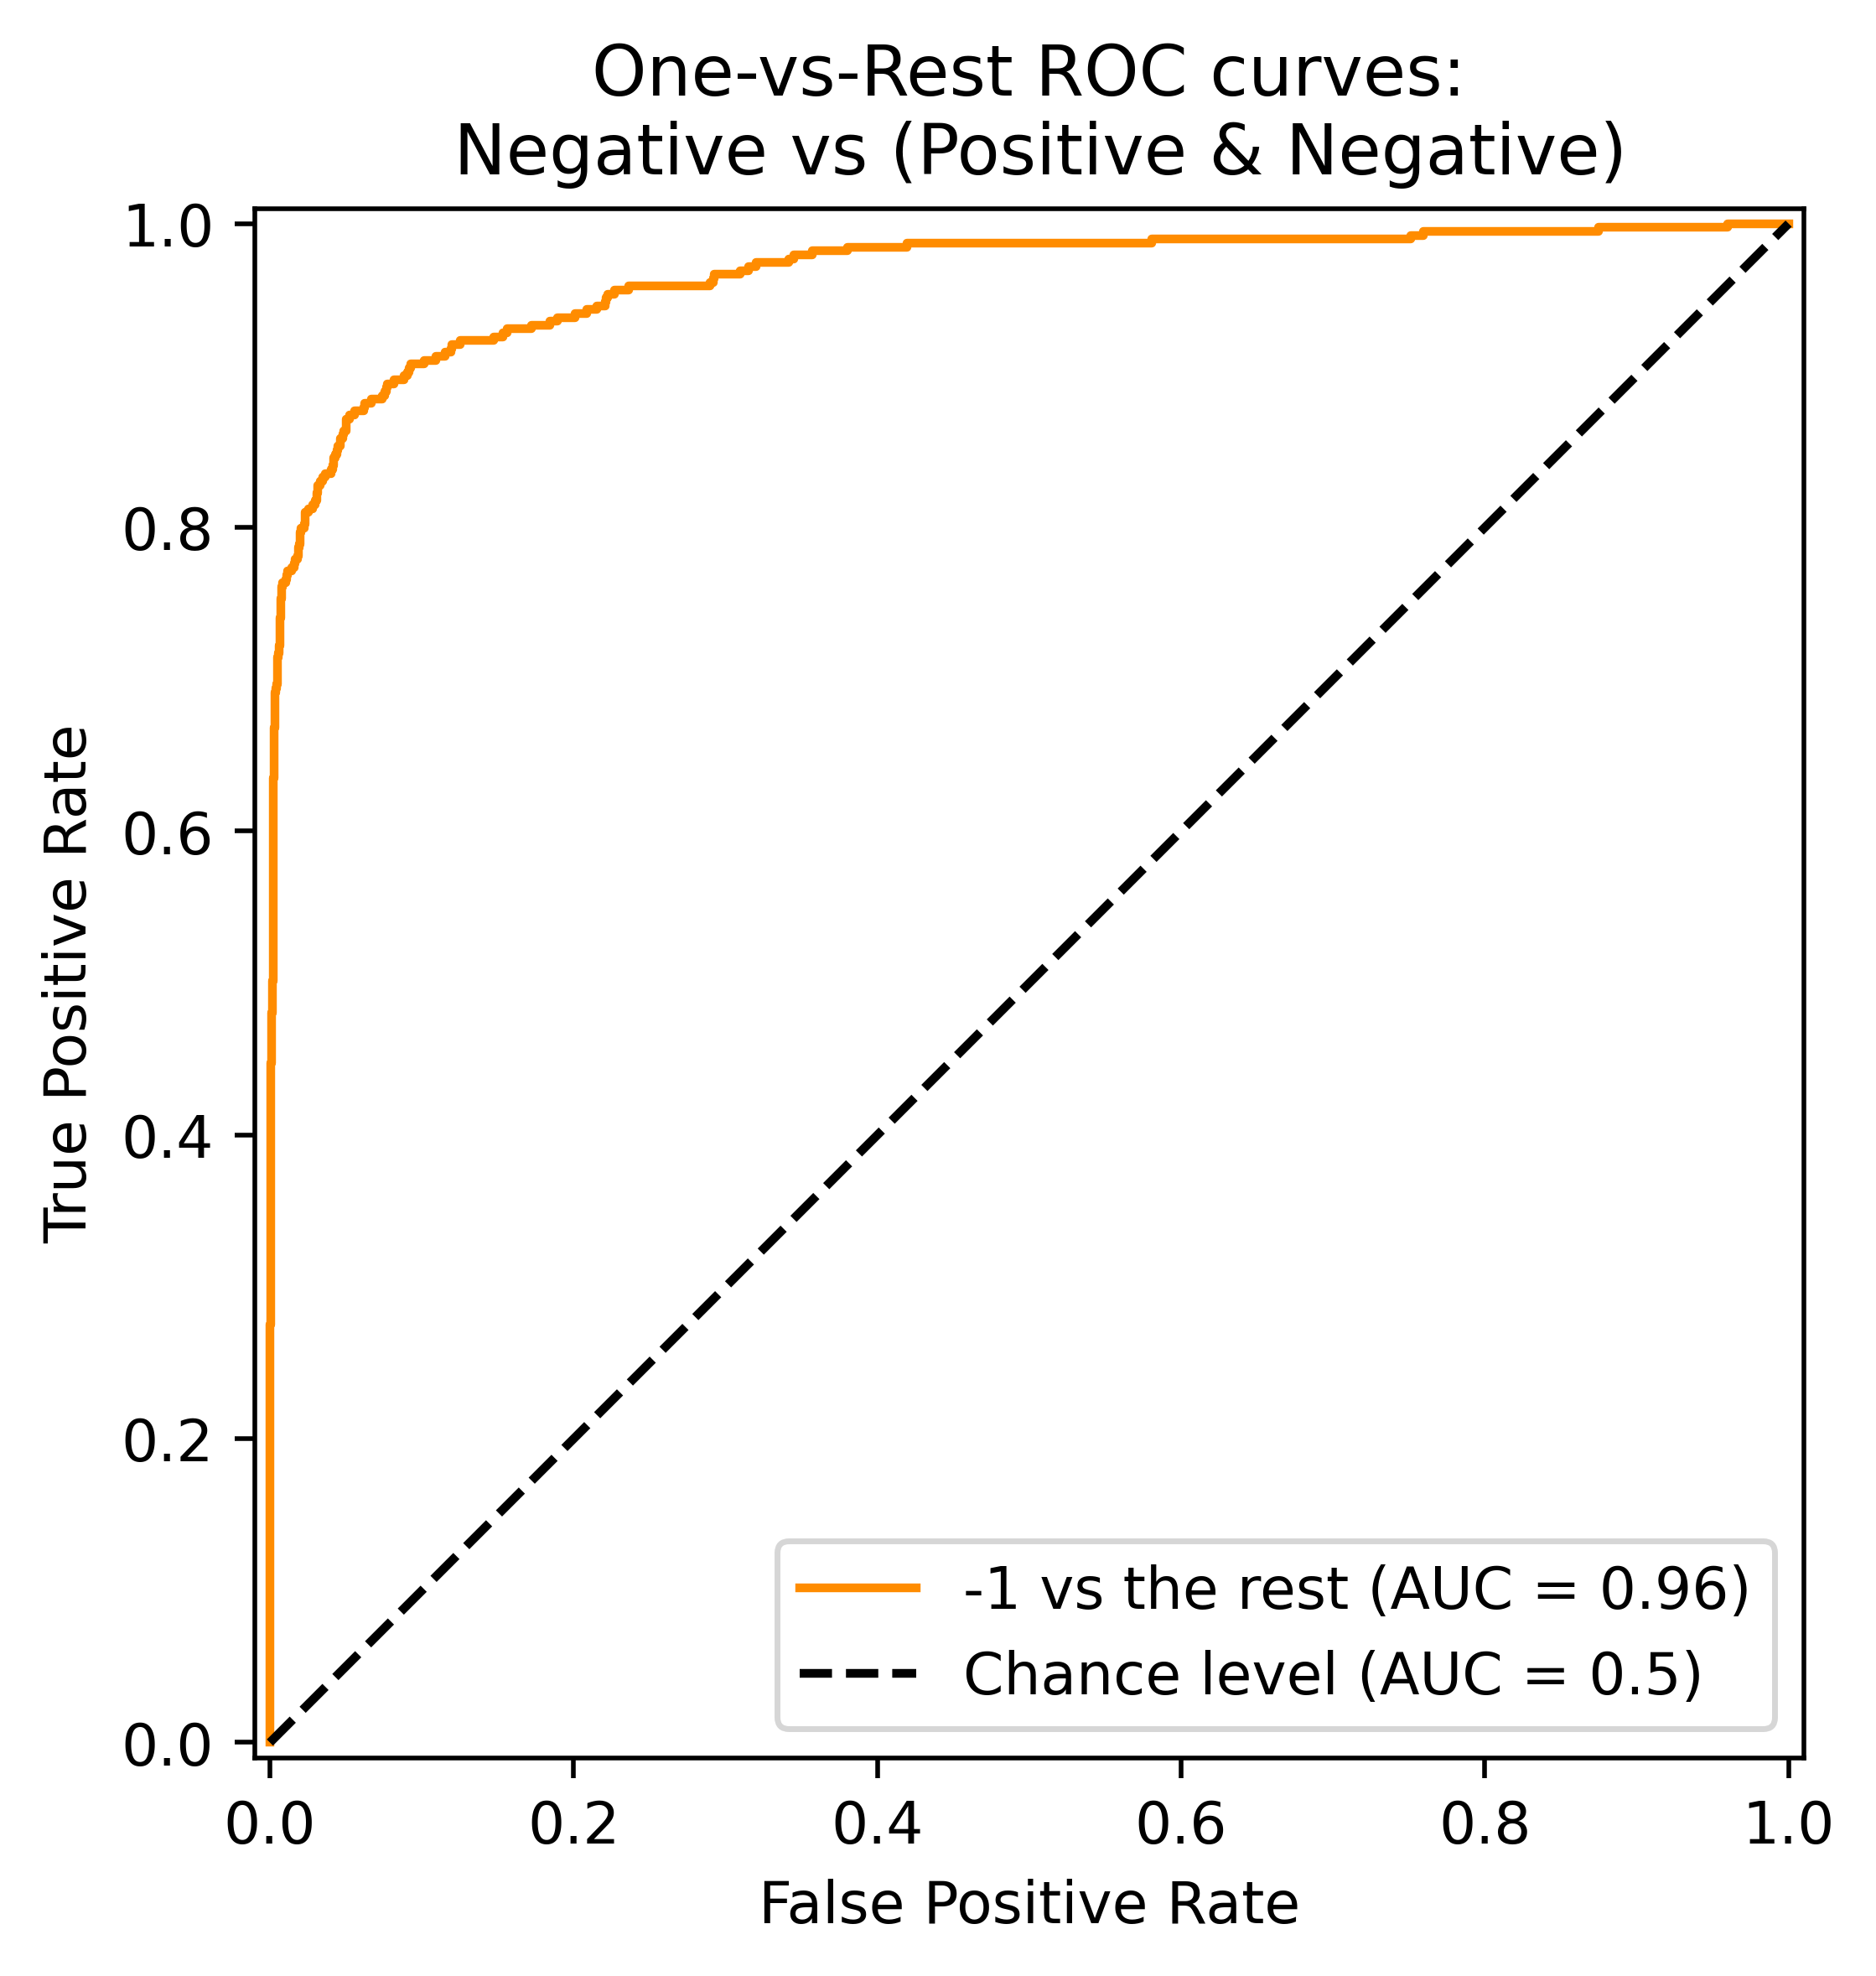

In [141]:
# for negative sentiments
# ROC curve showing an individual class
class_of_interest = -1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Negative vs (Positive & Negative)",
)

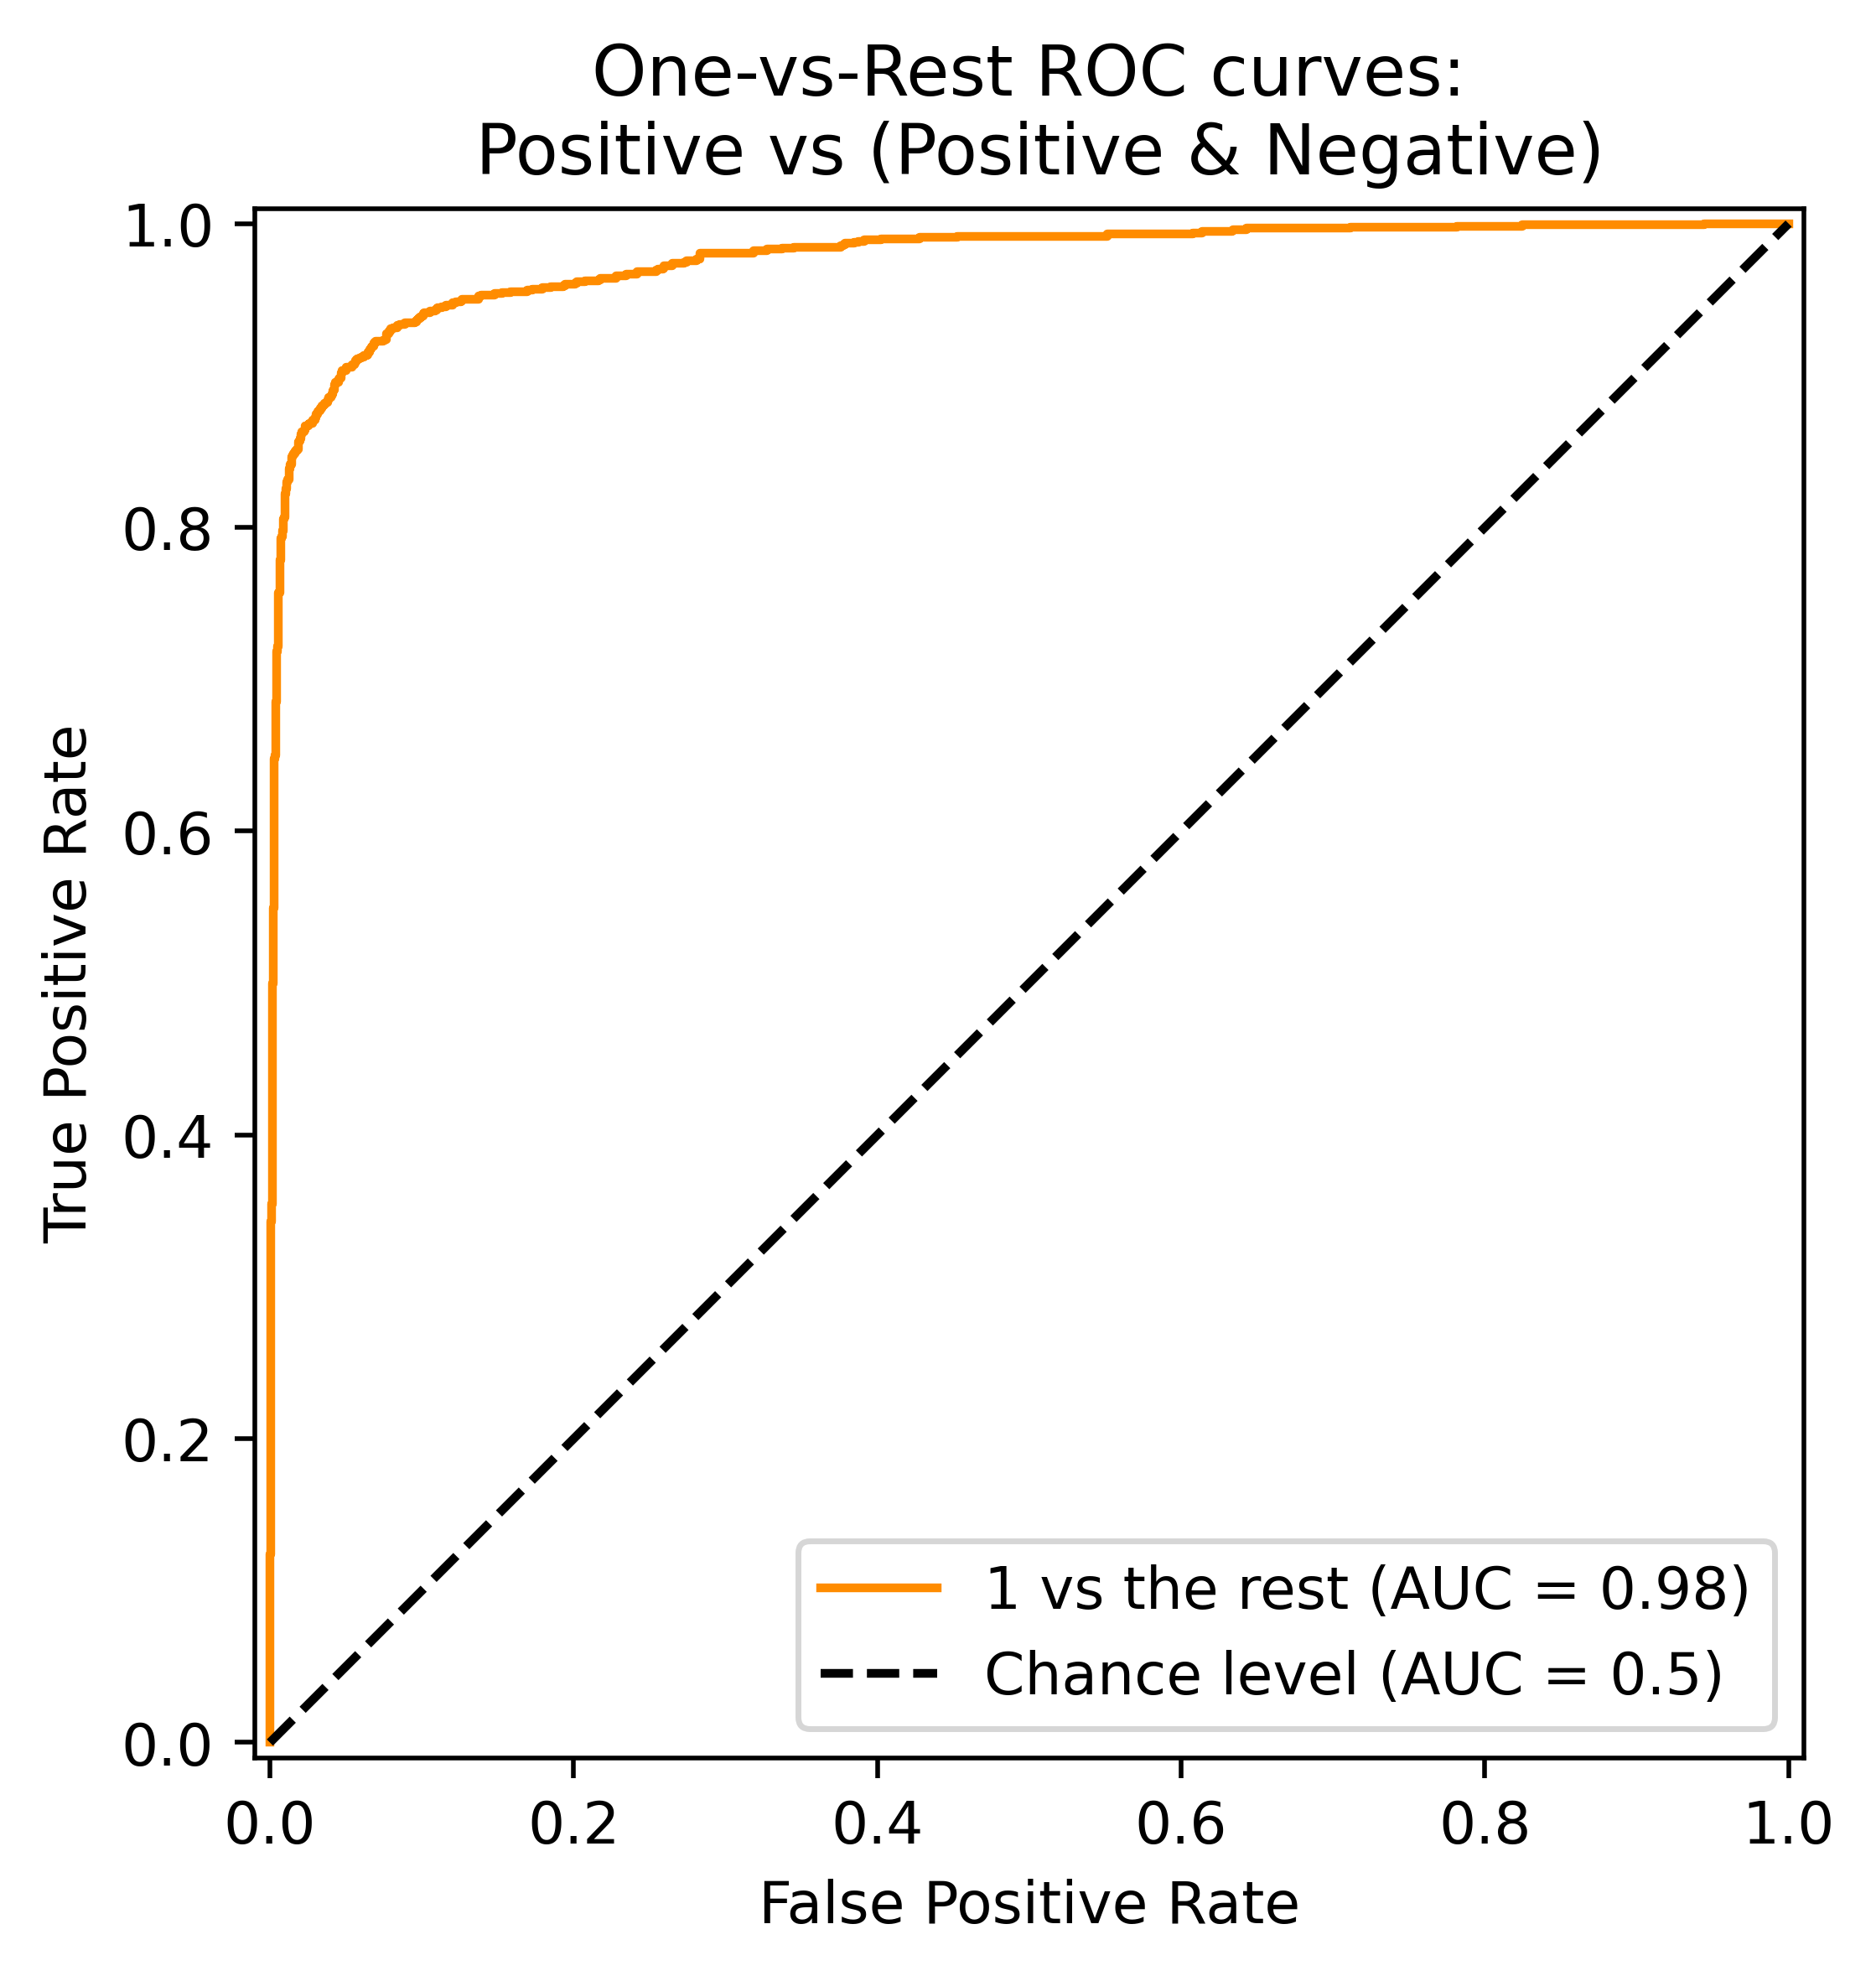

In [142]:
# for positive sentiments
# ROC curve showing an individual class
class_of_interest = 1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Positive vs (Positive & Negative)",
)

### ROC Micro-Averaged

Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics. In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferred.

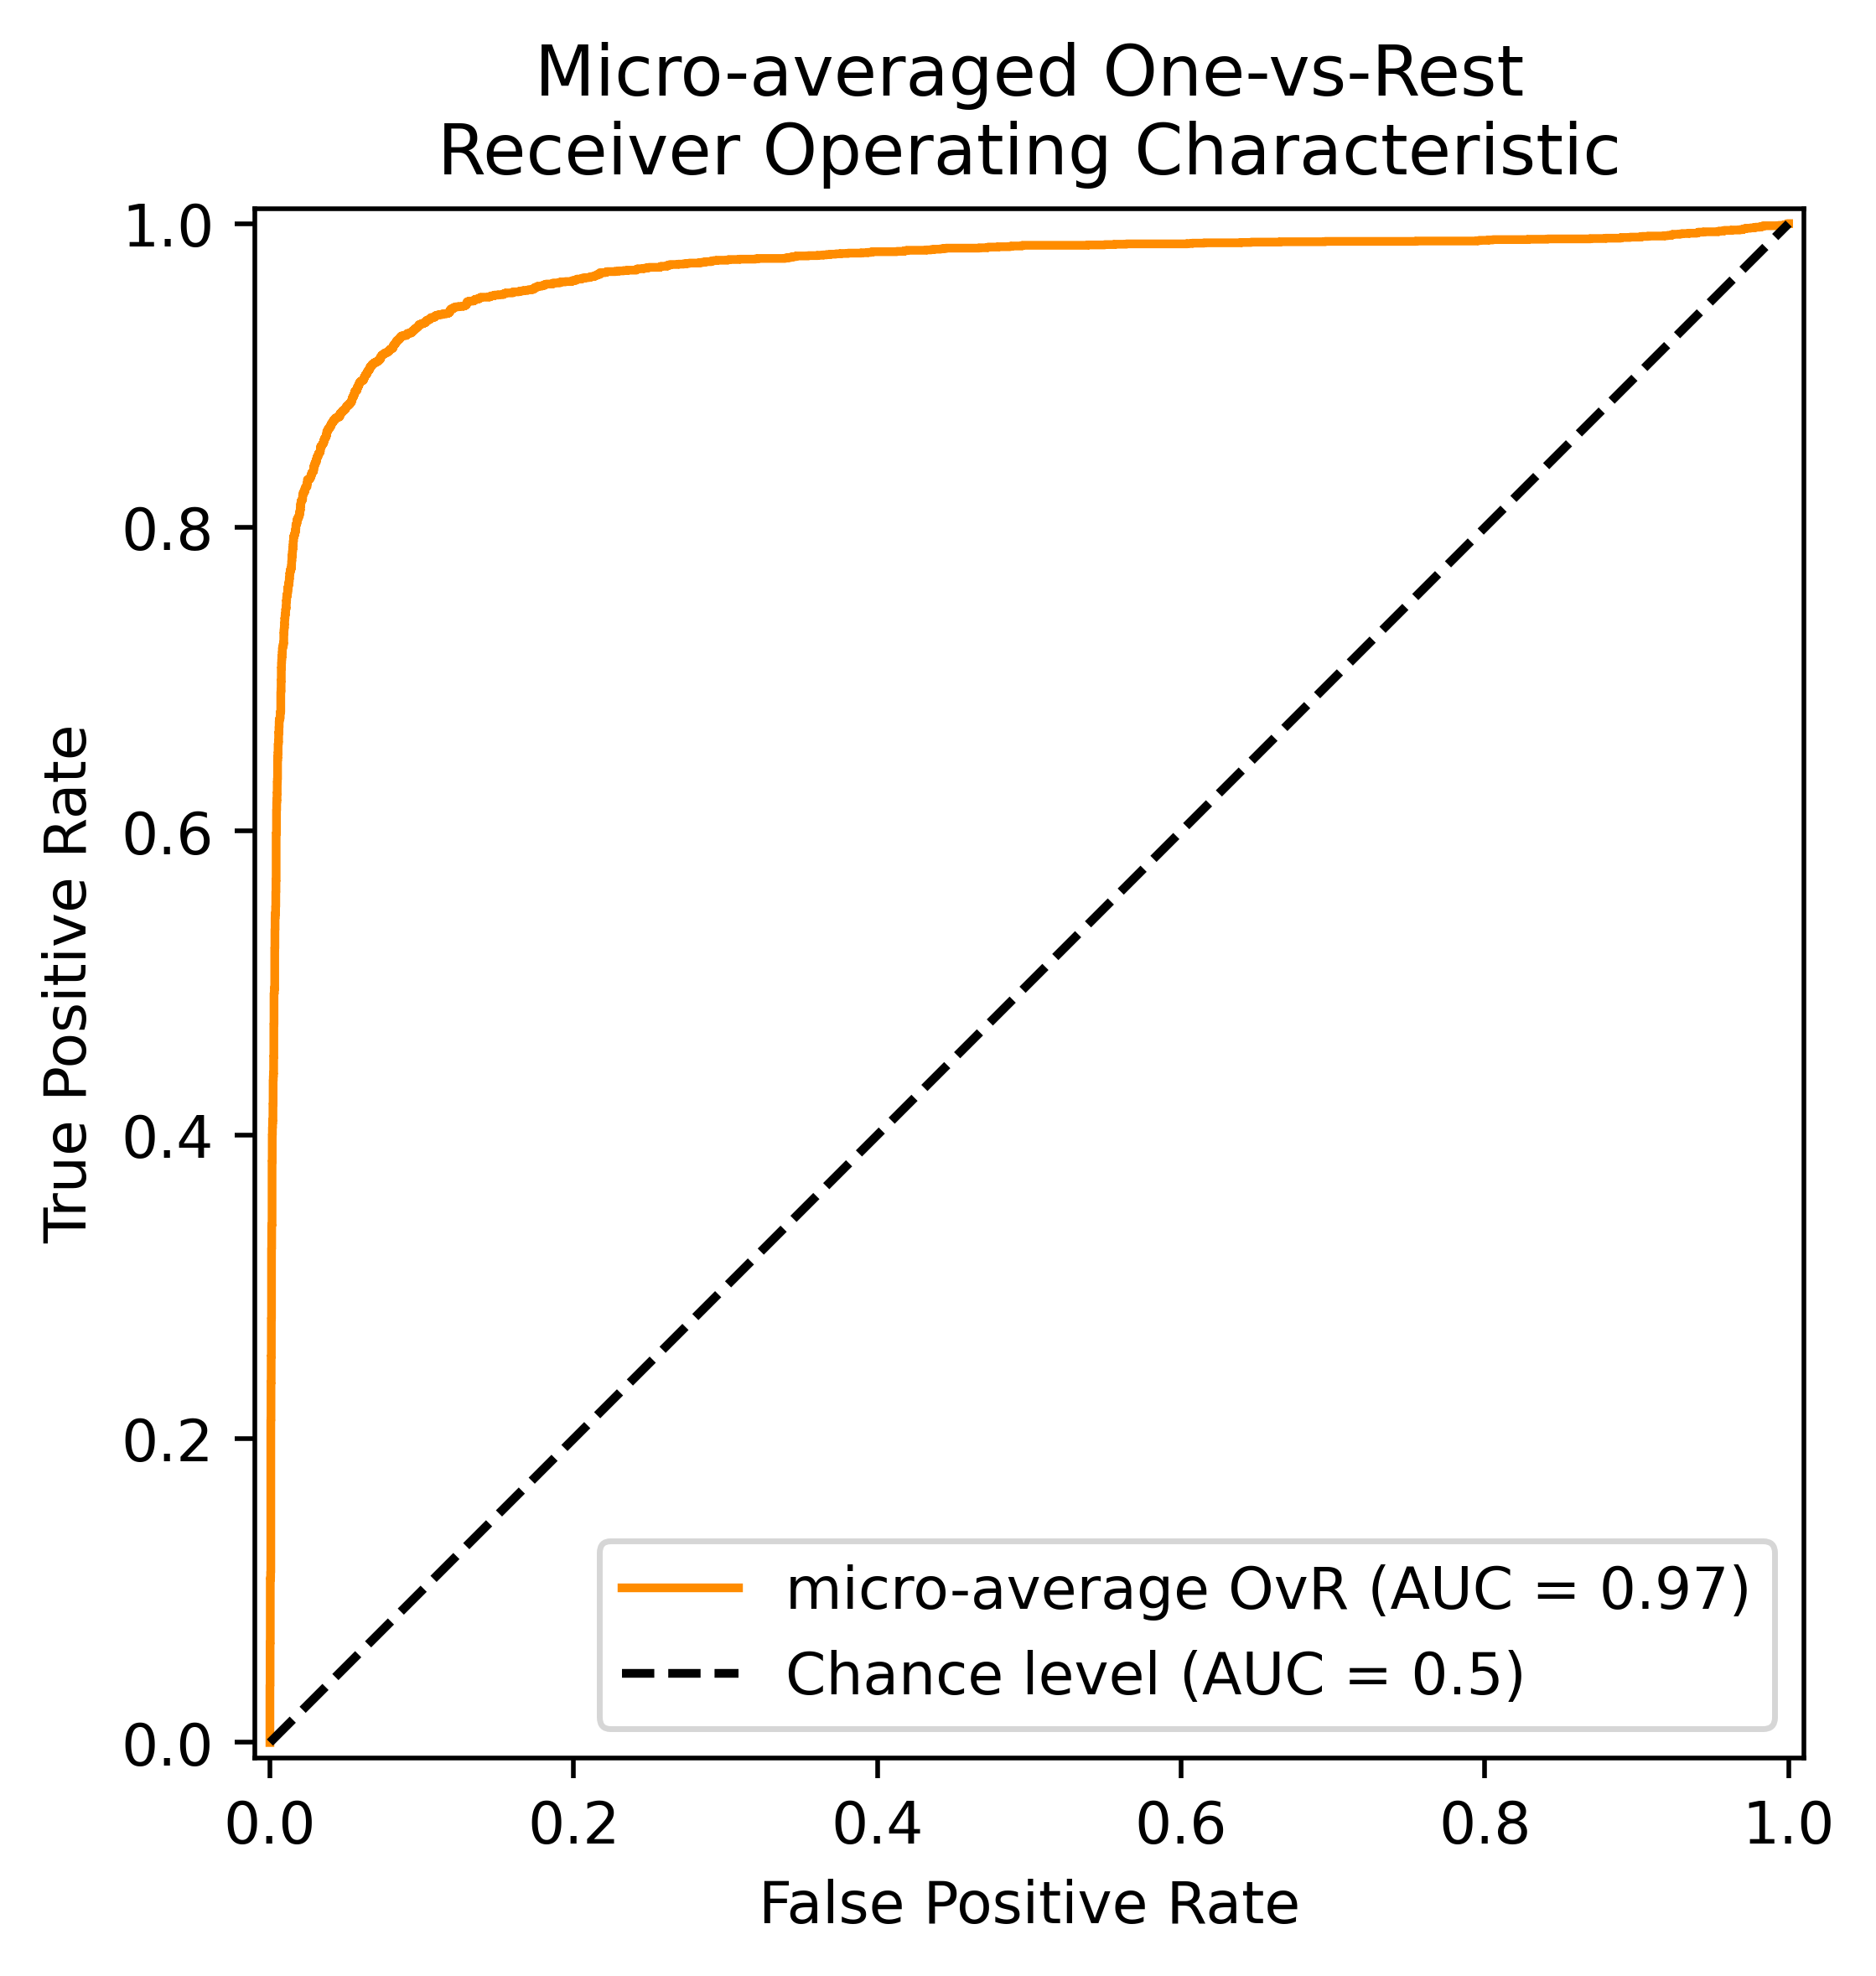

In [143]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [144]:
# computing ROC-AUC score
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9677051475504954


In [145]:
# Calculate ROC curve and ROC AUC for each class
from sklearn.metrics import roc_curve

fpr = {}
tpr = {}
thresholds = {}
roc_auc = {}

for i, class_ in enumerate(label_binarizer.classes_):
    fpr[class_], tpr[class_], thresholds[class_] = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[class_] = roc_auc_score(y_onehot_test[:, i], y_score[:, i])

# Calculate micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = roc_auc_score(y_onehot_test, y_score, average="micro")

# Export ROC data to CSV
roc_data = []
for key in roc_auc:
    for fp, tp, thres in zip(fpr[key], tpr[key], thresholds[key]):
        roc_data.append([key, fp, tp, thres, roc_auc[key]])

roc_df = pd.DataFrame(roc_data, columns=['Class', 'FPR', 'TPR', 'Thresholds', 'AUC'])
roc_df.to_csv('roc_data/1/roc_data_bow.csv', index=False)

print("Saved.")

Saved.


# Repeated K-Fold Cross Validation

In [ ]:

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_text = tfidf_vectorizer_text.fit_transform(X['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_url = tfidf_vectorizer_url.fit_transform(X['base_url'])

# Creating TF-IDF vectorizer for company_names
tfidf_vectorizer_company = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_company = tfidf_vectorizer_company.fit_transform(X['company_names'])

# Concatenating the TF-IDF matrices horizontally
X_tfidf_combined = hstack([X_tfidf_text, X_tfidf_url, X_tfidf_company])

In [ ]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)
X_bow_text = bow_vectorizer_text.fit_transform(X['text'])

bow_vectorizer_url = CountVectorizer(max_features=1000)
X_bow_url = bow_vectorizer_url.fit_transform(X['base_url'])

bow_vectorizer_company = CountVectorizer(max_features=1000)
X_bow_company = bow_vectorizer_company.fit_transform(X['company_names'])

X_bow_combined = hstack([X_bow_text, X_bow_url, X_bow_company])

In [ ]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
    Regressor = LogisticRegression(random_state=50,max_iter=50, solver='newton-cg')
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # evaluate model
    scores = cross_val_score(Regressor, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>1 mean=0.91986920 se=0.002
>2 mean=0.91958819 se=0.001
>3 mean=0.91975957 se=0.001
>4 mean=0.92000920 se=0.001
>5 mean=0.91969085 se=0.001
>6 mean=0.91972063 se=0.001
>7 mean=0.91974852 se=0.001
>8 mean=0.91966403 se=0.001
>9 mean=0.91968154 se=0.001


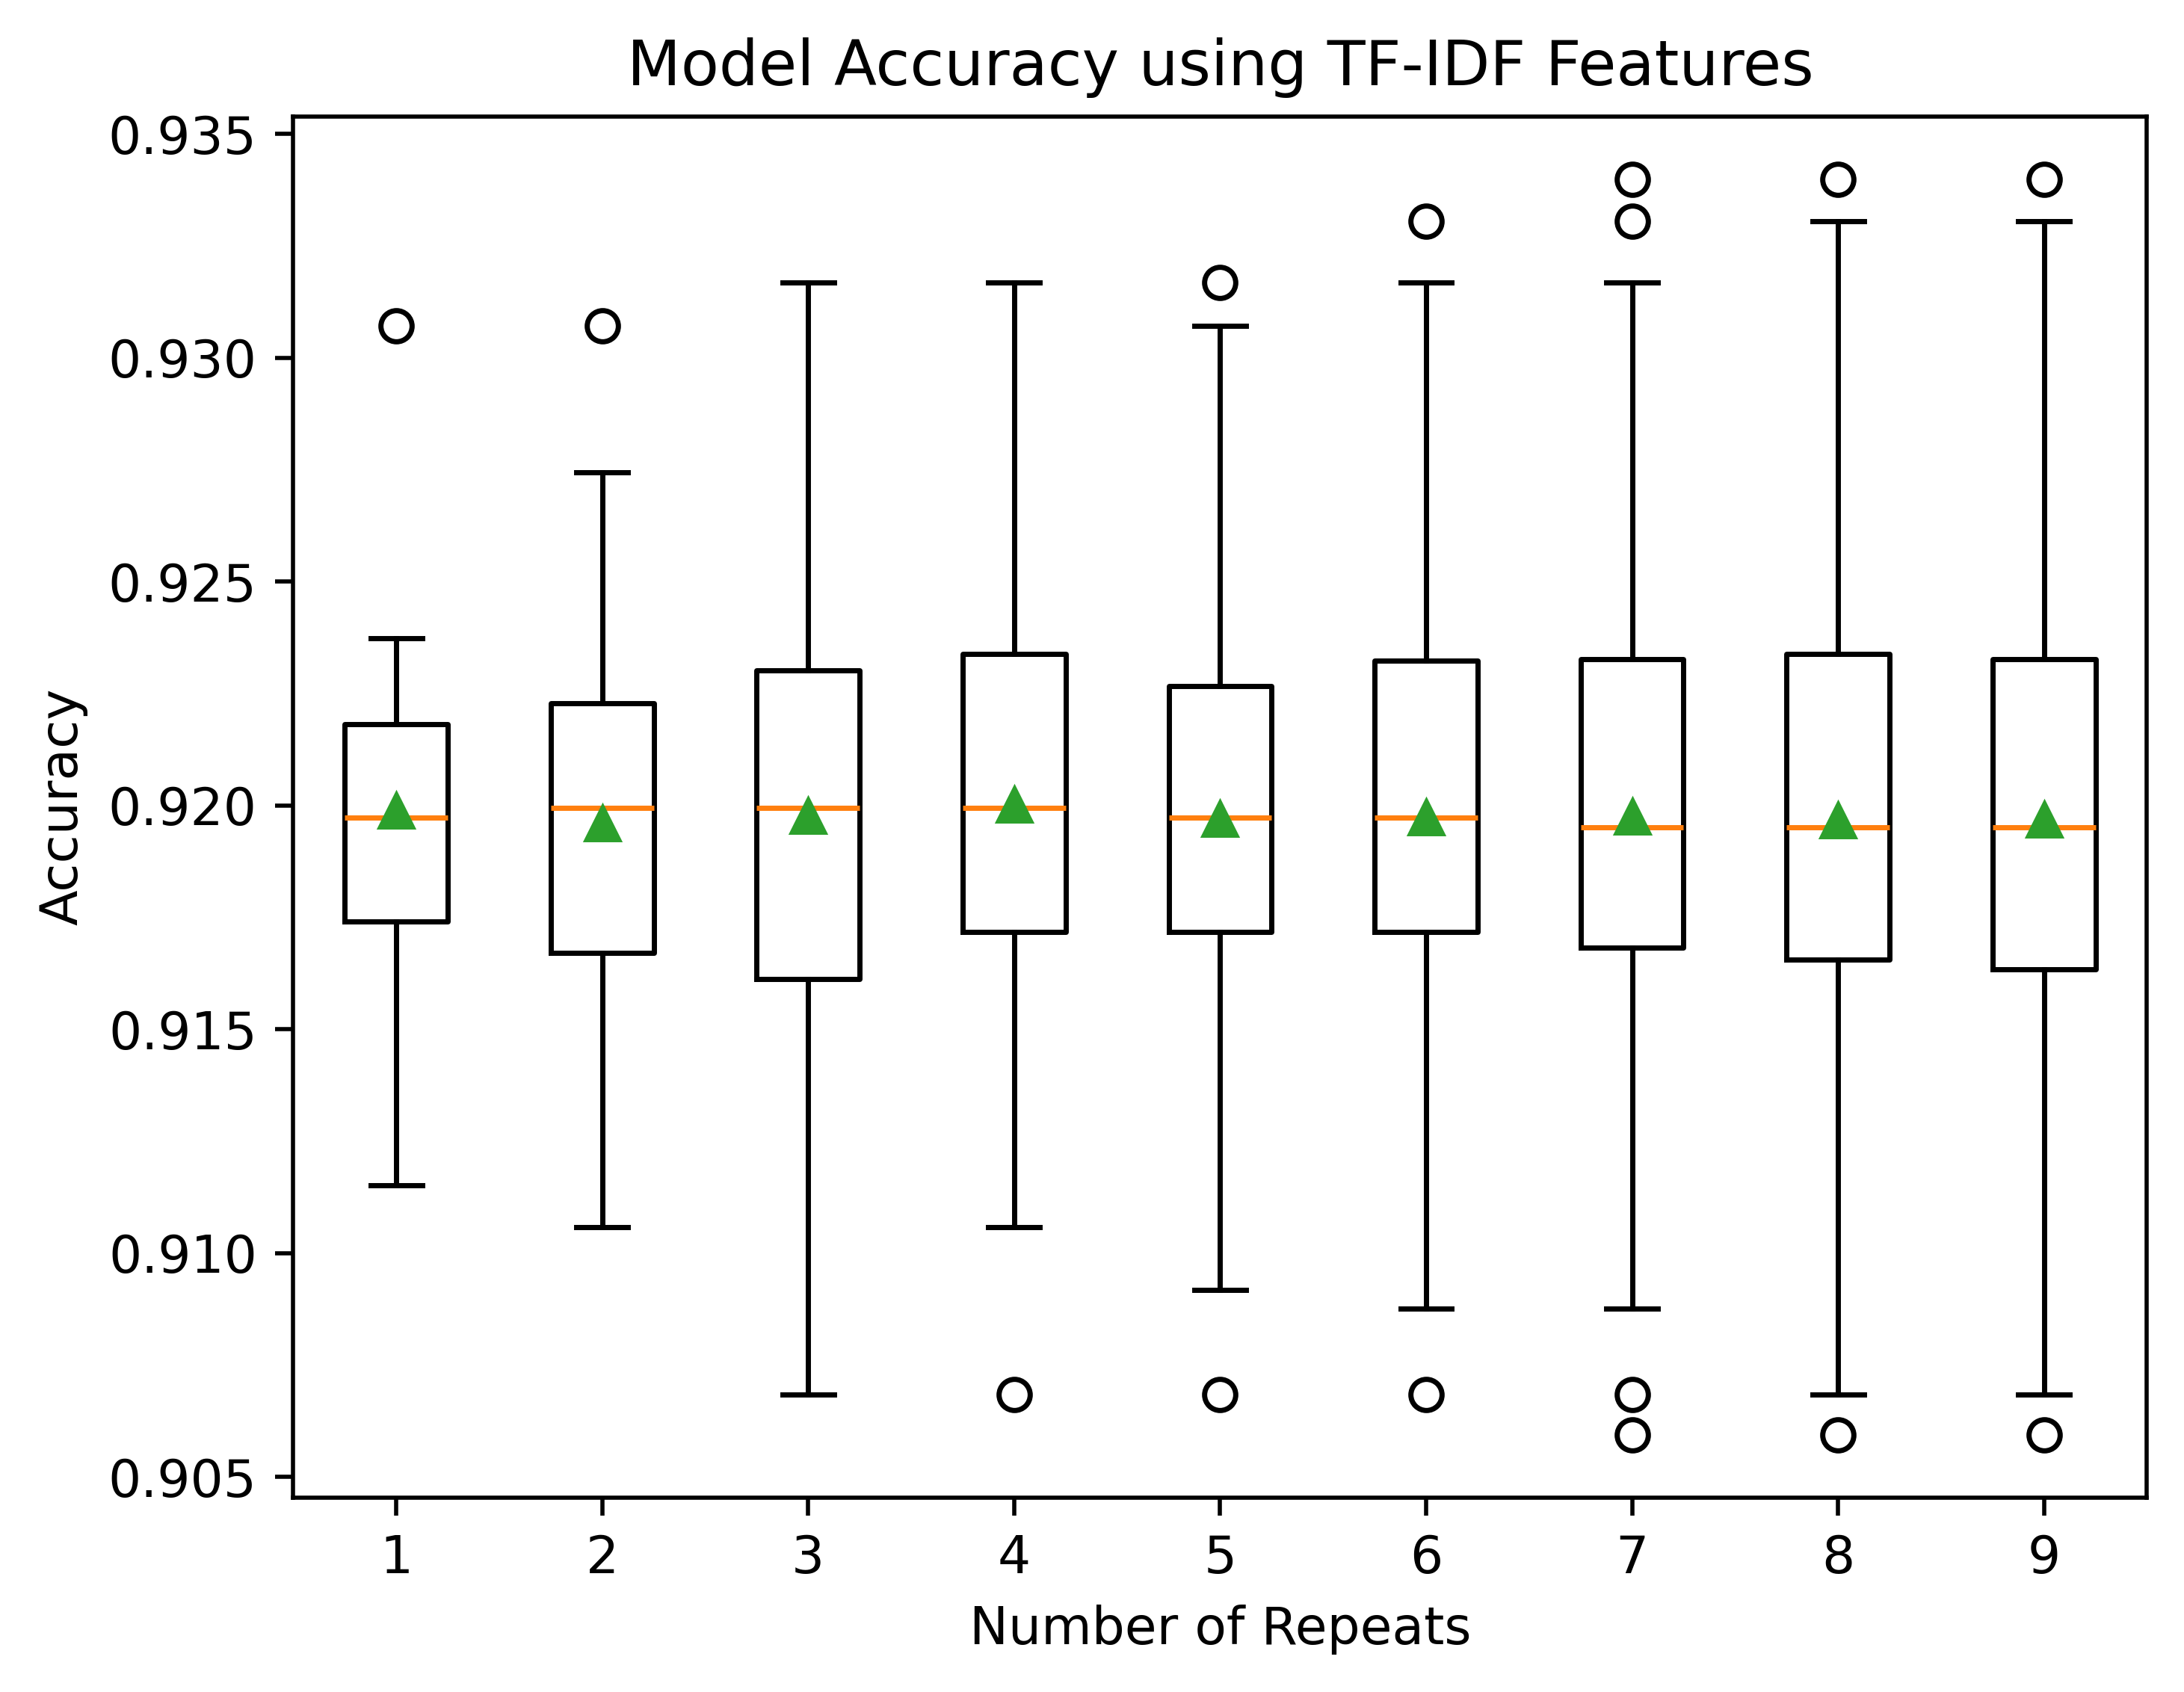

In [ ]:
repeats = range(1,10)
results = list()
from scipy.stats import sem
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_tfidf_combined, Y, r)
	# summarize
	print('>%d mean=%.8f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

>1 mean=0.93330244 se=0.001
>2 mean=0.93325559 se=0.001
>3 mean=0.93320852 se=0.001
>4 mean=0.93332555 se=0.001
>5 mean=0.93321774 se=0.001
>6 mean=0.93320847 se=0.001
>7 mean=0.93304804 se=0.001
>8 mean=0.93296272 se=0.001
>9 mean=0.93300036 se=0.001


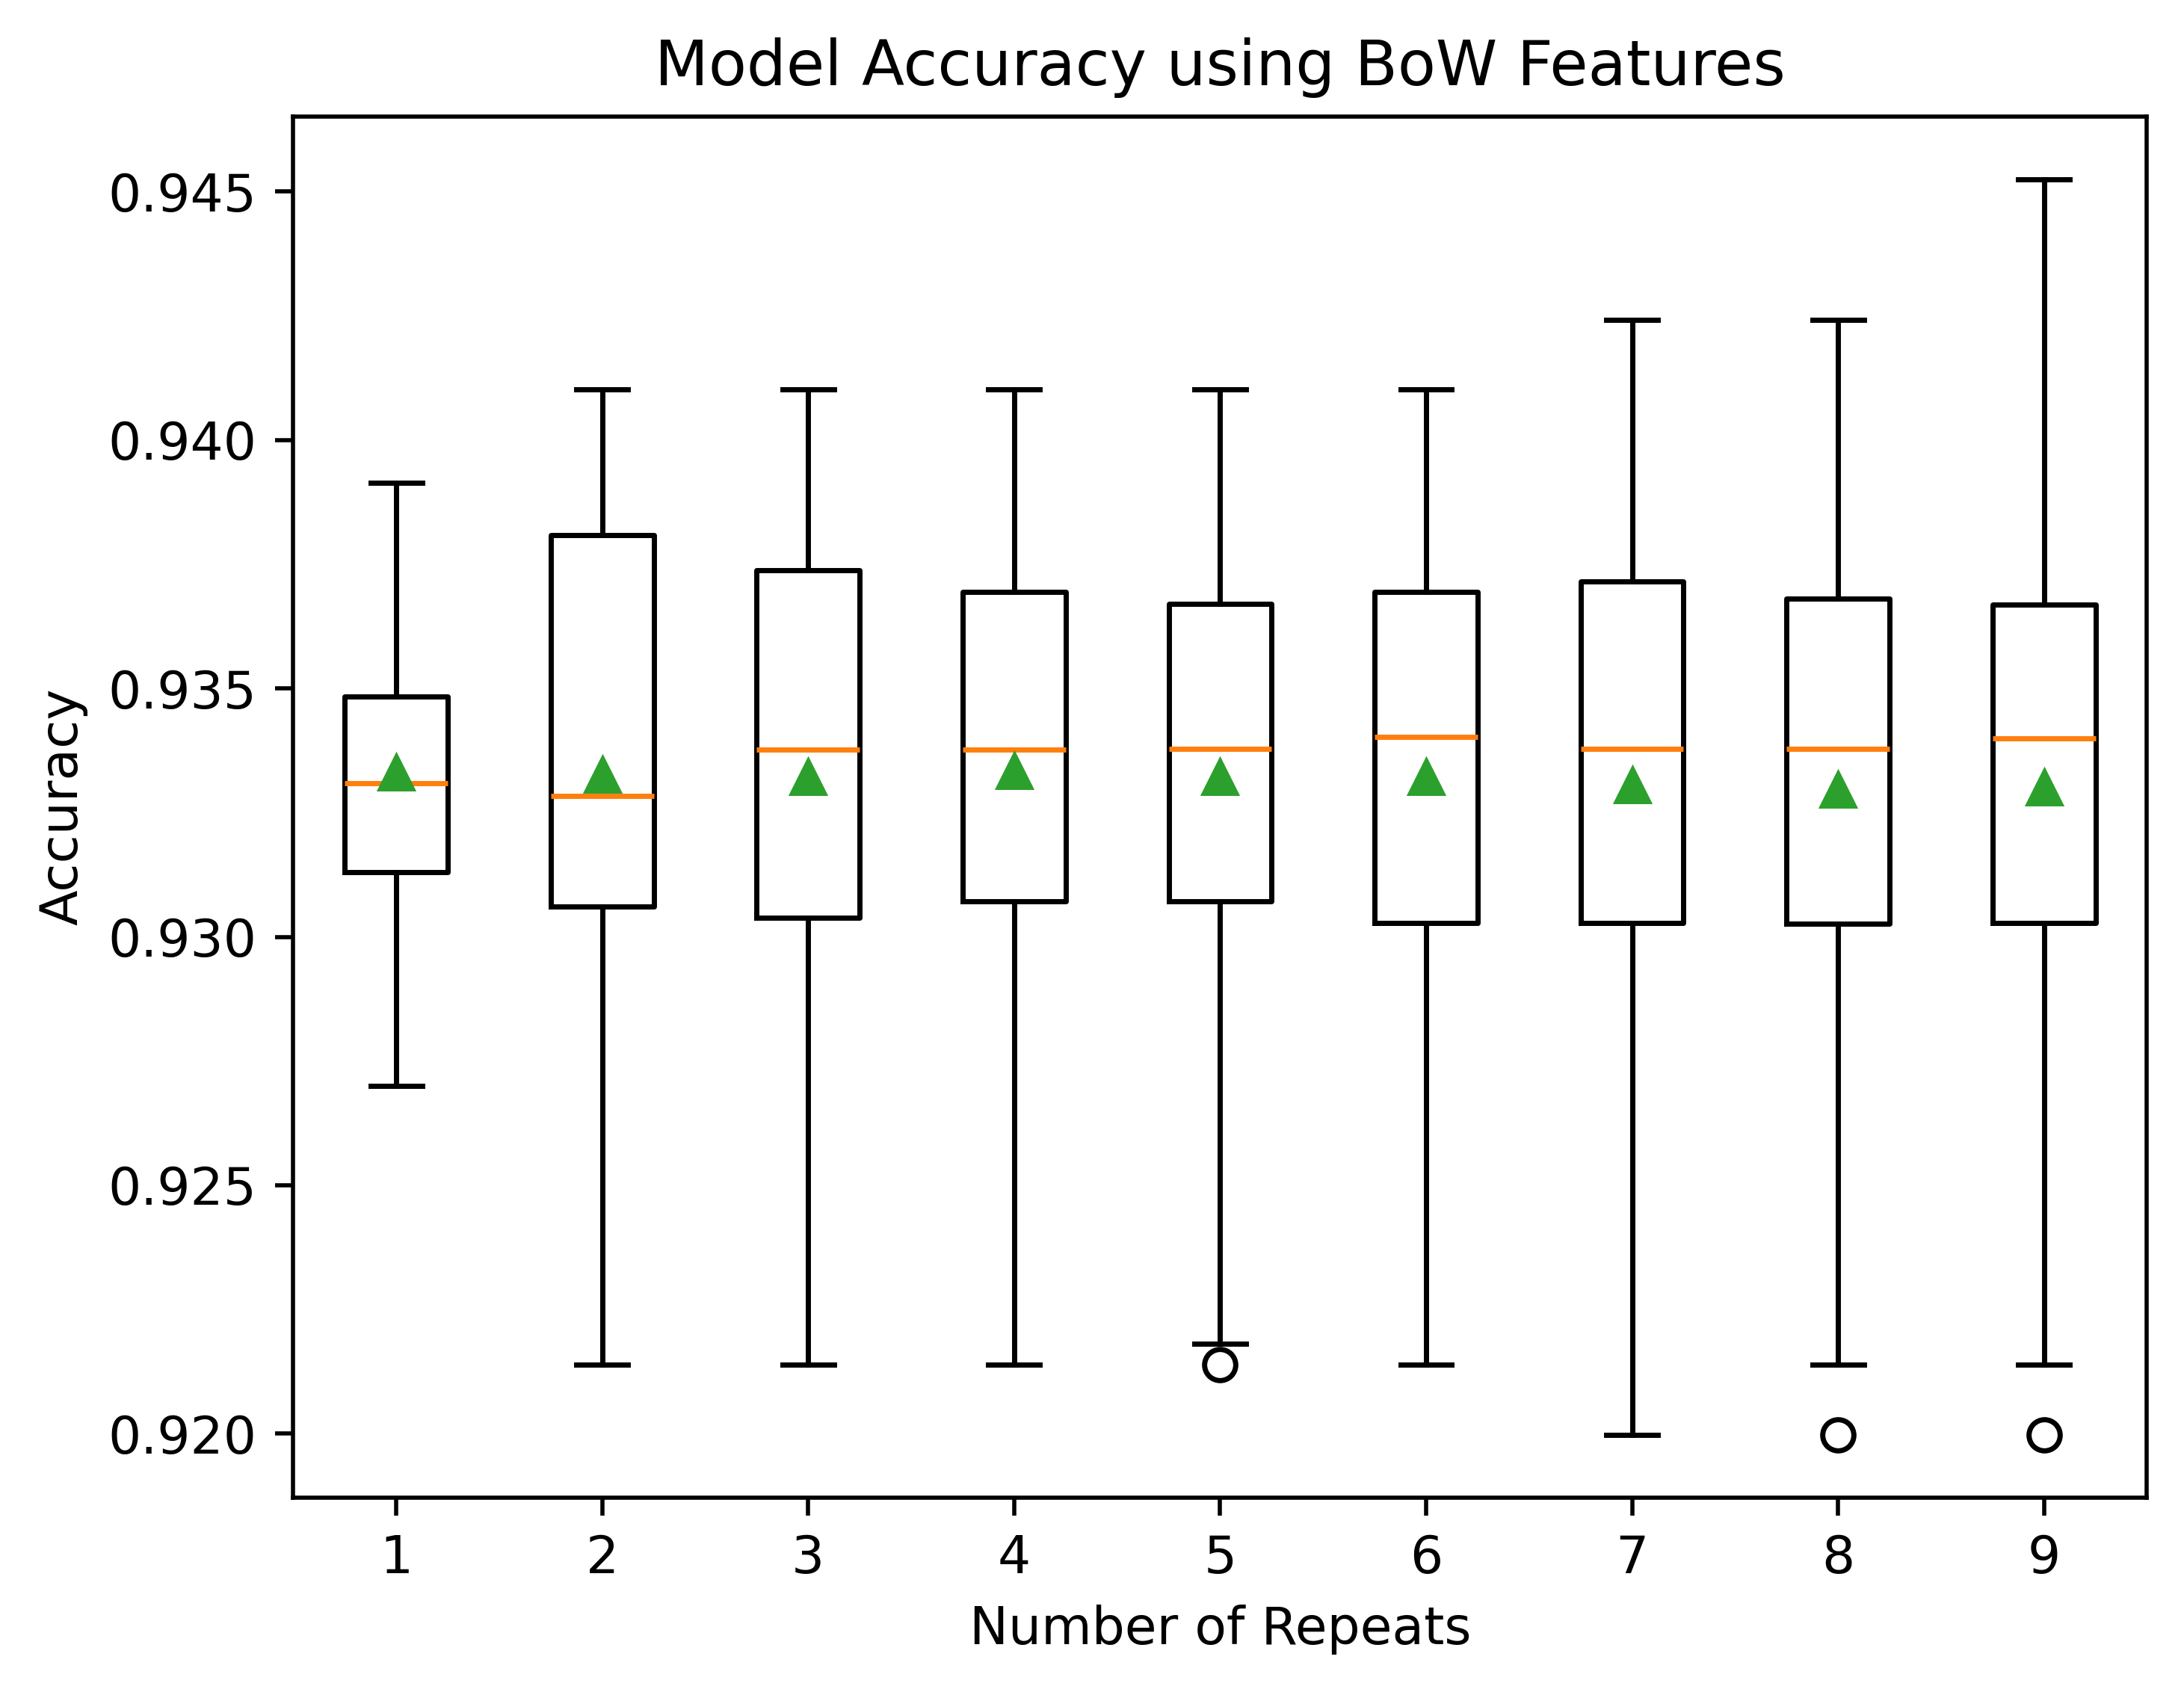

In [ ]:
repeats = range(1,10)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_bow_combined, Y, r)
	# summarize
	print('>%d mean=%.8f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()